In [1]:
import numpy as np
import pandas as pd
import psutil as ps
import os
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from Utility import draw_bitmap
import time

myProcess = ps.Process(os.getpid())
nb_feature = 5
nb_mdt = 479
split_ratio = 0.3
df = pd.read_csv('./data/train_sm.csv').values

def load_data():
    train_df, test_df = train_test_split(df, test_size=split_ratio)
    X_train = train_df[:, 2:2+nb_feature]
    y_train = train_df[:, -1]
    X_test = test_df[:, 2:2+nb_feature]
    y_test = test_df[:, -1]
    #print X_train.shape, y_train.shape
    #print X_train[:3], y_train[:3]
    #print X_test.shape, y_test.shape
    #print X_test[:3], y_test[:3]
    return X_train, y_train, X_test, y_test

def load_pixel_data(nb_feature):
    df = pd.read_csv('./data/heatmap_pixel_1m.csv').values
    data = df[:, :nb_feature]     
    return data

# Linear regression
def build_lin():
    model = linear_model.LinearRegression()
    return model

# K-NN
def build_knn():
    model = KNeighborsRegressor(n_neighbors=3, weights='uniform')
    return model

# Random forest
def build_rf():
    model = RandomForestRegressor(n_estimators=100, max_depth=30, max_features='auto')
    return model

# Decision tree
def build_dt():
    model = DecisionTreeRegressor(max_depth=30)
    return model

# Gradient Boosting
def build_gb():    
    model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
    return model

#Kriging
def build_kg():
    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
        + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
    model = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    return model

# Neural Network
def build_nn():
    def create_model():
        model = Sequential()    
        model.add(Dense(512, activation='relu', input_dim = nb_feature)) 
        model.add(Dense(512, activation='relu'))    
        model.add(Dense(512, activation='relu'))     
        model.add(Dense(512, activation='relu'))   
        model.add(Dense(1))     
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    model = KerasRegressor(build_fn=create_model, epochs=1000, batch_size=32, shuffle=True, verbose=1)
    return model

def build_model(option):
    fmap = {'lin':build_lin, 'knn':build_knn, 'rf':build_rf, 'dt':build_dt, 'nn':build_nn, 'gb':build_gb, 'kg':build_kg}
    return fmap[option]()

Using TensorFlow backend.


In [ ]:
model_option = 'nn'         # rf, nn, lin, dt, gb, knn, kg
iteration = 100
memory = 0
rmse = 0
err_mean = 0
err_std = 0
err_cdf = [0] * int(round(nb_mdt*split_ratio))    
hmap_z = [0] * (105*27)
hmap_test = load_pixel_data(nb_feature)
train_time = begin_time = end_time = 0

for _ in range(iteration):
    X_train, y_train, X_test, y_test = load_data()
    begin_time = time.time()  
    model = build_model(model_option)    
    model.fit(X_train, y_train)
    end_time = time.time()
    y_pred = model.predict(X_test)
    hmap_pred = model.predict(hmap_test)
    
    testerr = sorted([abs(y_pred[i] - y_test[i]) for i in range(len(y_test))])
    err_mean += np.mean(testerr)       
    err_std  += np.std(testerr)          # first caculate std for each iteration, then avg all stds
    err_cdf  = np.add(err_cdf, testerr)
    rmse += (mean_squared_error(y_test, y_pred))**(0.5)
    train_time += (end_time - begin_time)
    memory += (myProcess.memory_info()[0]/2.**20)   # RSS in MB
    hmap_z = np.add(hmap_z, hmap_pred)
    
np.set_printoptions(suppress=True)    #suppress scientific notation
[err_mean, err_std, rmse, train_time, memory] = np.divide([err_mean, err_std, rmse, train_time, memory], iteration)
err_cdf = np.divide(err_cdf, iteration)
hmap_z  = np.divide(hmap_z, iteration)

print '------' + model_option + '------'
print ('mean:%f \nstd:%f \nrmse:%f \ntime:%f \nmemory:%f') % (err_mean, err_std, rmse, train_time, memory)
print ('total memory:%f') % (myProcess.memory_info()[0]/2.**20)
print list(err_cdf)

Epoch 1/1000
335/335 [==============================] - 0s - loss: 3942.5833     
Epoch 2/1000
335/335 [==============================] - 0s - loss: 1218.3810     
Epoch 3/1000
335/335 [==============================] - 0s - loss: 261.9914     
Epoch 4/1000
335/335 [==============================] - 0s - loss: 139.2607     
Epoch 5/1000
335/335 [==============================] - 0s - loss: 46.3525     
Epoch 6/1000
335/335 [==============================] - 0s - loss: 16.3205     
Epoch 7/1000
335/335 [==============================] - 0s - loss: 12.1929     
Epoch 8/1000
335/335 [==============================] - 0s - loss: 9.5725     
Epoch 9/1000
335/335 [==============================] - 0s - loss: 7.7348     
Epoch 10/1000
335/335 [==============================] - 0s - loss: 8.2164     
Epoch 11/1000
335/335 [==============================] - 0s - loss: 6.0130     
Epoch 12/1000
335/335 [==============================] - 0s - loss: 4.9007     - ETA: 0s - loss: 4.65
Epoch 13/1000


335/335 [==============================] - 0s - loss: 0.5735     
Epoch 104/1000
335/335 [==============================] - 0s - loss: 0.3894     
Epoch 105/1000
335/335 [==============================] - 0s - loss: 0.6370     
Epoch 106/1000
335/335 [==============================] - 0s - loss: 0.3081     
Epoch 107/1000
335/335 [==============================] - 0s - loss: 0.6015     
Epoch 108/1000
335/335 [==============================] - 0s - loss: 0.7561     
Epoch 109/1000
335/335 [==============================] - 0s - loss: 0.5591     
Epoch 110/1000
335/335 [==============================] - 0s - loss: 0.4247     
Epoch 111/1000
335/335 [==============================] - 0s - loss: 0.1859     
Epoch 112/1000
335/335 [==============================] - 0s - loss: 0.2950     
Epoch 113/1000
335/335 [==============================] - 0s - loss: 0.2371     
Epoch 114/1000
335/335 [==============================] - 0s - loss: 0.2788     
Epoch 115/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.8550     
Epoch 205/1000
335/335 [==============================] - 0s - loss: 0.3828     
Epoch 206/1000
335/335 [==============================] - 0s - loss: 0.3206     
Epoch 207/1000
335/335 [==============================] - 0s - loss: 0.3584     
Epoch 208/1000
335/335 [==============================] - 0s - loss: 0.3554     
Epoch 209/1000
335/335 [==============================] - 0s - loss: 0.6781     
Epoch 210/1000
335/335 [==============================] - 0s - loss: 0.3325     
Epoch 211/1000
335/335 [==============================] - 0s - loss: 0.7385     
Epoch 212/1000
335/335 [==============================] - 0s - loss: 0.2813     
Epoch 213/1000
335/335 [==============================] - 0s - loss: 3.6993     
Epoch 214/1000
335/335 [==============================] - 0s - loss: 2.0966     
Epoch 215/1000
335/335 [==============================] - 0s - loss: 1.6202     
Epoch 216/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.4804     
Epoch 306/1000
335/335 [==============================] - 0s - loss: 1.0437     
Epoch 307/1000
335/335 [==============================] - 0s - loss: 0.3857     
Epoch 308/1000
335/335 [==============================] - 0s - loss: 0.3666     
Epoch 309/1000
335/335 [==============================] - 0s - loss: 0.2818     
Epoch 310/1000
335/335 [==============================] - 0s - loss: 1.0320     
Epoch 311/1000
335/335 [==============================] - 0s - loss: 1.1664     
Epoch 312/1000
335/335 [==============================] - 0s - loss: 0.2234     
Epoch 313/1000
335/335 [==============================] - 0s - loss: 0.4001     
Epoch 314/1000
335/335 [==============================] - 0s - loss: 0.7083     
Epoch 315/1000
335/335 [==============================] - 0s - loss: 0.2904     
Epoch 316/1000
335/335 [==============================] - 0s - loss: 0.5765     
Epoch 317/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.8903     
Epoch 407/1000
335/335 [==============================] - 0s - loss: 0.9470     
Epoch 408/1000
335/335 [==============================] - 0s - loss: 0.4160     
Epoch 409/1000
335/335 [==============================] - 0s - loss: 0.2217     
Epoch 410/1000
335/335 [==============================] - 0s - loss: 0.2455     
Epoch 411/1000
335/335 [==============================] - 0s - loss: 0.6157     
Epoch 412/1000
335/335 [==============================] - 0s - loss: 1.4302     
Epoch 413/1000
335/335 [==============================] - 0s - loss: 1.8837     
Epoch 414/1000
335/335 [==============================] - 0s - loss: 3.5654     
Epoch 415/1000
335/335 [==============================] - 0s - loss: 1.4893     
Epoch 416/1000
335/335 [==============================] - 0s - loss: 1.4229     
Epoch 417/1000
335/335 [==============================] - 0s - loss: 0.6862     
Epoch 418/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.5118     
Epoch 508/1000
335/335 [==============================] - 0s - loss: 0.1943     
Epoch 509/1000
335/335 [==============================] - 0s - loss: 0.1067     
Epoch 510/1000
335/335 [==============================] - 0s - loss: 0.1055     
Epoch 511/1000
335/335 [==============================] - 0s - loss: 0.1227     
Epoch 512/1000
335/335 [==============================] - 0s - loss: 0.3357     
Epoch 513/1000
335/335 [==============================] - 0s - loss: 0.1767     
Epoch 514/1000
335/335 [==============================] - 0s - loss: 0.1915     
Epoch 515/1000
335/335 [==============================] - 0s - loss: 0.3910     
Epoch 516/1000
335/335 [==============================] - 0s - loss: 0.4206     
Epoch 517/1000
335/335 [==============================] - 0s - loss: 0.1870     
Epoch 518/1000
335/335 [==============================] - 0s - loss: 0.1908     
Epoch 519/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.3283     
Epoch 609/1000
335/335 [==============================] - 0s - loss: 0.3806     
Epoch 610/1000
335/335 [==============================] - 0s - loss: 0.4525     
Epoch 611/1000
335/335 [==============================] - 0s - loss: 0.2005     
Epoch 612/1000
335/335 [==============================] - 0s - loss: 0.1876     
Epoch 613/1000
335/335 [==============================] - 0s - loss: 0.1980     
Epoch 614/1000
335/335 [==============================] - 0s - loss: 0.0610     
Epoch 615/1000
335/335 [==============================] - 0s - loss: 0.1658     
Epoch 616/1000
335/335 [==============================] - 0s - loss: 0.1431     
Epoch 617/1000
335/335 [==============================] - 0s - loss: 0.1501     
Epoch 618/1000
335/335 [==============================] - 0s - loss: 0.1778     
Epoch 619/1000
335/335 [==============================] - 0s - loss: 0.2193     
Epoch 620/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.2887     
Epoch 710/1000
335/335 [==============================] - 0s - loss: 0.1076     
Epoch 711/1000
335/335 [==============================] - 0s - loss: 0.1516     
Epoch 712/1000
335/335 [==============================] - 0s - loss: 0.3986     
Epoch 713/1000
335/335 [==============================] - 0s - loss: 0.6199     
Epoch 714/1000
335/335 [==============================] - 0s - loss: 0.7511     
Epoch 715/1000
335/335 [==============================] - 0s - loss: 0.5433     
Epoch 716/1000
335/335 [==============================] - 0s - loss: 0.0712     
Epoch 717/1000
335/335 [==============================] - 0s - loss: 0.2850     
Epoch 718/1000
335/335 [==============================] - 0s - loss: 0.0856     
Epoch 719/1000
335/335 [==============================] - 0s - loss: 0.1877     
Epoch 720/1000
335/335 [==============================] - 0s - loss: 0.1302     
Epoch 721/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.2003     
Epoch 811/1000
335/335 [==============================] - 0s - loss: 0.1511     
Epoch 812/1000
335/335 [==============================] - 0s - loss: 0.1589     
Epoch 813/1000
335/335 [==============================] - 0s - loss: 0.1393     
Epoch 814/1000
335/335 [==============================] - 0s - loss: 0.1675     
Epoch 815/1000
335/335 [==============================] - 0s - loss: 0.2074     
Epoch 816/1000
335/335 [==============================] - 0s - loss: 0.3161     
Epoch 817/1000
335/335 [==============================] - 0s - loss: 0.4733     
Epoch 818/1000
335/335 [==============================] - 0s - loss: 0.5252     
Epoch 819/1000
335/335 [==============================] - 0s - loss: 0.2001     
Epoch 820/1000
335/335 [==============================] - 0s - loss: 0.3697     
Epoch 821/1000
335/335 [==============================] - 0s - loss: 0.6397     
Epoch 822/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.3090     
Epoch 912/1000
335/335 [==============================] - 0s - loss: 0.1671     
Epoch 913/1000
335/335 [==============================] - 0s - loss: 0.1833     
Epoch 914/1000
335/335 [==============================] - 0s - loss: 0.1125     
Epoch 915/1000
335/335 [==============================] - 0s - loss: 0.0919     
Epoch 916/1000
335/335 [==============================] - 0s - loss: 0.0842     
Epoch 917/1000
335/335 [==============================] - 0s - loss: 0.0773     
Epoch 918/1000
335/335 [==============================] - 0s - loss: 0.3410     
Epoch 919/1000
335/335 [==============================] - 0s - loss: 0.5362     
Epoch 920/1000
335/335 [==============================] - 0s - loss: 0.1187     
Epoch 921/1000
335/335 [==============================] - 0s - loss: 0.1624     
Epoch 922/1000
335/335 [==============================] - 0s - loss: 0.0379     
Epoch 923/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 5.2277     
Epoch 12/1000
335/335 [==============================] - 0s - loss: 4.2476     
Epoch 13/1000
335/335 [==============================] - 0s - loss: 3.2700     
Epoch 14/1000
335/335 [==============================] - 0s - loss: 2.8715     
Epoch 15/1000
335/335 [==============================] - 0s - loss: 2.4609     
Epoch 16/1000
335/335 [==============================] - 0s - loss: 2.4587     
Epoch 17/1000
335/335 [==============================] - 0s - loss: 2.1363     
Epoch 18/1000
335/335 [==============================] - 0s - loss: 1.9993     
Epoch 19/1000
335/335 [==============================] - 0s - loss: 2.2623     
Epoch 20/1000
335/335 [==============================] - 0s - loss: 2.0636     
Epoch 21/1000
335/335 [==============================] - 0s - loss: 2.0597     
Epoch 22/1000
335/335 [==============================] - 0s - loss: 1.9706     
Epoch 23/1000
335/335 [==============================]

335/335 [==============================] - 0s - loss: 1.8657     
Epoch 114/1000
335/335 [==============================] - 0s - loss: 1.2695     
Epoch 115/1000
335/335 [==============================] - 0s - loss: 0.4199     
Epoch 116/1000
335/335 [==============================] - 0s - loss: 1.1325     
Epoch 117/1000
335/335 [==============================] - 0s - loss: 1.6103     
Epoch 118/1000
335/335 [==============================] - 0s - loss: 1.2452     
Epoch 119/1000
335/335 [==============================] - 0s - loss: 0.4171     
Epoch 120/1000
335/335 [==============================] - 0s - loss: 0.3533     
Epoch 121/1000
335/335 [==============================] - 0s - loss: 0.4961     
Epoch 122/1000
335/335 [==============================] - 0s - loss: 0.7488     
Epoch 123/1000
335/335 [==============================] - 0s - loss: 0.6222     
Epoch 124/1000
335/335 [==============================] - 0s - loss: 0.4069     
Epoch 125/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.6603     
Epoch 215/1000
335/335 [==============================] - 0s - loss: 0.9938     
Epoch 216/1000
335/335 [==============================] - 0s - loss: 4.8411     
Epoch 217/1000
335/335 [==============================] - 0s - loss: 2.5848     
Epoch 218/1000
335/335 [==============================] - 0s - loss: 0.8798     
Epoch 219/1000
335/335 [==============================] - 0s - loss: 3.9734     
Epoch 220/1000
335/335 [==============================] - 0s - loss: 3.8412     
Epoch 221/1000
335/335 [==============================] - 0s - loss: 0.9929     
Epoch 222/1000
335/335 [==============================] - 0s - loss: 0.9604     
Epoch 223/1000
335/335 [==============================] - 0s - loss: 1.1546     
Epoch 224/1000
335/335 [==============================] - 0s - loss: 0.9195     
Epoch 225/1000
335/335 [==============================] - 0s - loss: 1.7316     
Epoch 226/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.5067     
Epoch 316/1000
335/335 [==============================] - 0s - loss: 0.6106     
Epoch 317/1000
335/335 [==============================] - 0s - loss: 0.4440     
Epoch 318/1000
335/335 [==============================] - 0s - loss: 0.2419     
Epoch 319/1000
335/335 [==============================] - 0s - loss: 0.6800     
Epoch 320/1000
335/335 [==============================] - 0s - loss: 1.8568     
Epoch 321/1000
335/335 [==============================] - 0s - loss: 0.8381     
Epoch 322/1000
335/335 [==============================] - 0s - loss: 0.7264     
Epoch 323/1000
335/335 [==============================] - 0s - loss: 0.3049     
Epoch 324/1000
335/335 [==============================] - 0s - loss: 0.2597     
Epoch 325/1000
335/335 [==============================] - 0s - loss: 0.5243     
Epoch 326/1000
335/335 [==============================] - 0s - loss: 0.5109     
Epoch 327/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1459     
Epoch 417/1000
335/335 [==============================] - 0s - loss: 0.3363     
Epoch 418/1000
335/335 [==============================] - 0s - loss: 2.4018     
Epoch 419/1000
335/335 [==============================] - 0s - loss: 0.8518     
Epoch 420/1000
335/335 [==============================] - 0s - loss: 1.5156     
Epoch 421/1000
335/335 [==============================] - 0s - loss: 1.3956     
Epoch 422/1000
335/335 [==============================] - 0s - loss: 2.2476     
Epoch 423/1000
335/335 [==============================] - 0s - loss: 4.0385     
Epoch 424/1000
335/335 [==============================] - 0s - loss: 2.6767     
Epoch 425/1000
335/335 [==============================] - 0s - loss: 10.5365     
Epoch 426/1000
335/335 [==============================] - 0s - loss: 7.6715     
Epoch 427/1000
335/335 [==============================] - 0s - loss: 2.7308     
Epoch 428/1000
335/335 [==================

335/335 [==============================] - 0s - loss: 0.6218     
Epoch 517/1000
335/335 [==============================] - 0s - loss: 0.2904     
Epoch 518/1000
335/335 [==============================] - 0s - loss: 1.8186     
Epoch 519/1000
335/335 [==============================] - 0s - loss: 0.5709     
Epoch 520/1000
335/335 [==============================] - 0s - loss: 0.1656     
Epoch 521/1000
335/335 [==============================] - 0s - loss: 1.3377     
Epoch 522/1000
335/335 [==============================] - 0s - loss: 1.7301     
Epoch 523/1000
335/335 [==============================] - 0s - loss: 1.9739     
Epoch 524/1000
335/335 [==============================] - 0s - loss: 2.0573     
Epoch 525/1000
335/335 [==============================] - 0s - loss: 1.6439     
Epoch 526/1000
335/335 [==============================] - 0s - loss: 0.9700     
Epoch 527/1000
335/335 [==============================] - 0s - loss: 1.2380     
Epoch 528/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.8226     
Epoch 618/1000
335/335 [==============================] - 0s - loss: 0.6026     
Epoch 619/1000
335/335 [==============================] - 0s - loss: 0.2911     
Epoch 620/1000
335/335 [==============================] - 0s - loss: 1.0372     
Epoch 621/1000
335/335 [==============================] - 0s - loss: 1.1179     
Epoch 622/1000
335/335 [==============================] - 0s - loss: 2.3567     
Epoch 623/1000
335/335 [==============================] - 0s - loss: 1.8239     
Epoch 624/1000
335/335 [==============================] - 0s - loss: 2.6794     
Epoch 625/1000
335/335 [==============================] - 0s - loss: 1.1740     
Epoch 626/1000
335/335 [==============================] - 0s - loss: 0.2399     
Epoch 627/1000
335/335 [==============================] - 0s - loss: 0.4630     
Epoch 628/1000
335/335 [==============================] - 0s - loss: 0.4782     
Epoch 629/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1092     
Epoch 719/1000
335/335 [==============================] - 0s - loss: 0.0782     
Epoch 720/1000
335/335 [==============================] - 0s - loss: 0.1864     
Epoch 721/1000
335/335 [==============================] - 0s - loss: 0.1261     
Epoch 722/1000
335/335 [==============================] - 0s - loss: 0.2105     
Epoch 723/1000
335/335 [==============================] - 0s - loss: 0.1624     
Epoch 724/1000
335/335 [==============================] - 0s - loss: 0.1470     
Epoch 725/1000
335/335 [==============================] - 0s - loss: 0.0769     
Epoch 726/1000
335/335 [==============================] - 0s - loss: 0.0726     
Epoch 727/1000
335/335 [==============================] - 0s - loss: 0.0960     
Epoch 728/1000
335/335 [==============================] - 0s - loss: 0.2049     
Epoch 729/1000
335/335 [==============================] - 0s - loss: 0.1493     
Epoch 730/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.6678     
Epoch 820/1000
335/335 [==============================] - 0s - loss: 0.5027     
Epoch 821/1000
335/335 [==============================] - 0s - loss: 0.4026     
Epoch 822/1000
335/335 [==============================] - 0s - loss: 0.4569     
Epoch 823/1000
335/335 [==============================] - 0s - loss: 0.3468     
Epoch 824/1000
335/335 [==============================] - 0s - loss: 0.0805     
Epoch 825/1000
335/335 [==============================] - 0s - loss: 1.6074     
Epoch 826/1000
335/335 [==============================] - 0s - loss: 0.9088     
Epoch 827/1000
335/335 [==============================] - 0s - loss: 1.5303     
Epoch 828/1000
335/335 [==============================] - 0s - loss: 0.5693     
Epoch 829/1000
335/335 [==============================] - 0s - loss: 3.1470     
Epoch 830/1000
335/335 [==============================] - 0s - loss: 2.2830     
Epoch 831/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1282     
Epoch 921/1000
335/335 [==============================] - 0s - loss: 0.1301     
Epoch 922/1000
335/335 [==============================] - 0s - loss: 0.1883     
Epoch 923/1000
335/335 [==============================] - 0s - loss: 0.1246     
Epoch 924/1000
335/335 [==============================] - 0s - loss: 0.0940     
Epoch 925/1000
335/335 [==============================] - 0s - loss: 0.1104     
Epoch 926/1000
335/335 [==============================] - 0s - loss: 0.1433     
Epoch 927/1000
335/335 [==============================] - 0s - loss: 0.4281     
Epoch 928/1000
335/335 [==============================] - 0s - loss: 0.6403     
Epoch 929/1000
335/335 [==============================] - 0s - loss: 0.6808     
Epoch 930/1000
335/335 [==============================] - 0s - loss: 0.4819     
Epoch 931/1000
335/335 [==============================] - 0s - loss: 0.8225     
Epoch 932/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 3.6765     
Epoch 21/1000
335/335 [==============================] - 0s - loss: 4.5120     
Epoch 22/1000
335/335 [==============================] - 0s - loss: 3.2254     
Epoch 23/1000
335/335 [==============================] - 0s - loss: 2.6114     
Epoch 24/1000
335/335 [==============================] - 0s - loss: 2.1682     
Epoch 25/1000
335/335 [==============================] - 0s - loss: 2.0219     
Epoch 26/1000
335/335 [==============================] - 0s - loss: 2.0914     
Epoch 27/1000
335/335 [==============================] - 0s - loss: 1.9611     
Epoch 28/1000
335/335 [==============================] - 0s - loss: 1.8711     
Epoch 29/1000
335/335 [==============================] - 0s - loss: 1.4903     
Epoch 30/1000
335/335 [==============================] - 0s - loss: 1.7386     
Epoch 31/1000
335/335 [==============================] - 0s - loss: 1.4226     
Epoch 32/1000
335/335 [==============================]

335/335 [==============================] - 0s - loss: 1.2877     
Epoch 123/1000
335/335 [==============================] - 0s - loss: 0.6295     
Epoch 124/1000
335/335 [==============================] - 0s - loss: 0.8316     
Epoch 125/1000
335/335 [==============================] - 0s - loss: 0.5126     
Epoch 126/1000
335/335 [==============================] - 0s - loss: 0.4803     
Epoch 127/1000
335/335 [==============================] - 0s - loss: 0.5578     
Epoch 128/1000
335/335 [==============================] - 0s - loss: 0.7435     
Epoch 129/1000
335/335 [==============================] - 0s - loss: 0.3812     
Epoch 130/1000
335/335 [==============================] - 0s - loss: 0.4228     
Epoch 131/1000
335/335 [==============================] - 0s - loss: 0.3584     
Epoch 132/1000
335/335 [==============================] - 0s - loss: 0.3971     
Epoch 133/1000
335/335 [==============================] - 0s - loss: 0.7504     
Epoch 134/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.5337     
Epoch 224/1000
335/335 [==============================] - 0s - loss: 0.7521     
Epoch 225/1000
335/335 [==============================] - 0s - loss: 0.5518     
Epoch 226/1000
335/335 [==============================] - 0s - loss: 0.3293     
Epoch 227/1000
335/335 [==============================] - 0s - loss: 0.1807     
Epoch 228/1000
335/335 [==============================] - 0s - loss: 0.2090     
Epoch 229/1000
335/335 [==============================] - 0s - loss: 0.2167     
Epoch 230/1000
335/335 [==============================] - 0s - loss: 0.1736     
Epoch 231/1000
335/335 [==============================] - 0s - loss: 0.7540     
Epoch 232/1000
335/335 [==============================] - 0s - loss: 0.1743     
Epoch 233/1000
335/335 [==============================] - 0s - loss: 0.4777     
Epoch 234/1000
335/335 [==============================] - 0s - loss: 0.4812     
Epoch 235/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.6739     
Epoch 325/1000
335/335 [==============================] - 0s - loss: 0.5169     
Epoch 326/1000
335/335 [==============================] - 0s - loss: 0.4769     
Epoch 327/1000
335/335 [==============================] - 0s - loss: 1.8029     
Epoch 328/1000
335/335 [==============================] - 0s - loss: 1.2729     
Epoch 329/1000
335/335 [==============================] - 0s - loss: 7.3285     
Epoch 330/1000
335/335 [==============================] - 0s - loss: 4.9646     
Epoch 331/1000
335/335 [==============================] - 0s - loss: 5.6055     
Epoch 332/1000
335/335 [==============================] - 0s - loss: 3.4825     
Epoch 333/1000
335/335 [==============================] - 0s - loss: 1.3181     
Epoch 334/1000
335/335 [==============================] - 0s - loss: 0.4883     
Epoch 335/1000
335/335 [==============================] - 0s - loss: 0.5427     
Epoch 336/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1906     
Epoch 426/1000
335/335 [==============================] - 0s - loss: 0.0732     
Epoch 427/1000
335/335 [==============================] - 0s - loss: 0.1160     
Epoch 428/1000
335/335 [==============================] - 0s - loss: 0.3621     
Epoch 429/1000
335/335 [==============================] - 0s - loss: 0.1189     
Epoch 430/1000
335/335 [==============================] - 0s - loss: 0.0906     
Epoch 431/1000
335/335 [==============================] - 0s - loss: 0.3534     
Epoch 432/1000
335/335 [==============================] - 0s - loss: 0.3169     
Epoch 433/1000
335/335 [==============================] - 0s - loss: 1.4460     
Epoch 434/1000
335/335 [==============================] - 0s - loss: 1.1917     
Epoch 435/1000
335/335 [==============================] - 0s - loss: 1.3126     
Epoch 436/1000
335/335 [==============================] - 0s - loss: 0.8548     
Epoch 437/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.0330     
Epoch 527/1000
335/335 [==============================] - 0s - loss: 0.8116     
Epoch 528/1000
335/335 [==============================] - 0s - loss: 0.6434     
Epoch 529/1000
335/335 [==============================] - 0s - loss: 0.7621     
Epoch 530/1000
335/335 [==============================] - 0s - loss: 0.4534     
Epoch 531/1000
335/335 [==============================] - 0s - loss: 1.5595     
Epoch 532/1000
335/335 [==============================] - 0s - loss: 0.2247     
Epoch 533/1000
335/335 [==============================] - 0s - loss: 0.5516     
Epoch 534/1000
335/335 [==============================] - 0s - loss: 0.6204     
Epoch 535/1000
335/335 [==============================] - 0s - loss: 1.4880     
Epoch 536/1000
335/335 [==============================] - 0s - loss: 4.3212     
Epoch 537/1000
335/335 [==============================] - 0s - loss: 3.4116     
Epoch 538/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.4349     
Epoch 628/1000
335/335 [==============================] - 0s - loss: 0.2693     
Epoch 629/1000
335/335 [==============================] - 0s - loss: 0.2974     
Epoch 630/1000
335/335 [==============================] - 0s - loss: 0.3590     
Epoch 631/1000
335/335 [==============================] - 0s - loss: 0.2306     
Epoch 632/1000
335/335 [==============================] - 0s - loss: 0.1100     
Epoch 633/1000
335/335 [==============================] - 0s - loss: 0.2236     
Epoch 634/1000
335/335 [==============================] - 0s - loss: 0.0833     
Epoch 635/1000
335/335 [==============================] - 0s - loss: 0.4760     
Epoch 636/1000
335/335 [==============================] - 0s - loss: 1.1407     
Epoch 637/1000
335/335 [==============================] - 0s - loss: 0.9246     
Epoch 638/1000
335/335 [==============================] - 0s - loss: 0.5309     
Epoch 639/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1459     
Epoch 729/1000
335/335 [==============================] - 0s - loss: 0.1685     
Epoch 730/1000
335/335 [==============================] - 0s - loss: 0.2364     
Epoch 731/1000
335/335 [==============================] - 0s - loss: 0.6375     
Epoch 732/1000
335/335 [==============================] - 0s - loss: 0.5472     
Epoch 733/1000
335/335 [==============================] - 0s - loss: 0.0979     
Epoch 734/1000
335/335 [==============================] - 0s - loss: 0.0774     
Epoch 735/1000
335/335 [==============================] - 0s - loss: 0.1063     
Epoch 736/1000
335/335 [==============================] - 0s - loss: 0.1117     
Epoch 737/1000
335/335 [==============================] - 0s - loss: 0.1337     
Epoch 738/1000
335/335 [==============================] - 0s - loss: 0.1205     
Epoch 739/1000
335/335 [==============================] - 0s - loss: 0.9016     
Epoch 740/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1213     
Epoch 830/1000
335/335 [==============================] - 0s - loss: 0.0592     
Epoch 831/1000
335/335 [==============================] - 0s - loss: 0.1837     
Epoch 832/1000
335/335 [==============================] - 0s - loss: 0.0975     
Epoch 833/1000
335/335 [==============================] - 0s - loss: 0.3915     
Epoch 834/1000
335/335 [==============================] - 0s - loss: 0.5731     
Epoch 835/1000
335/335 [==============================] - 0s - loss: 0.6437     
Epoch 836/1000
335/335 [==============================] - 0s - loss: 0.2170     
Epoch 837/1000
335/335 [==============================] - 0s - loss: 0.1403     
Epoch 838/1000
335/335 [==============================] - 0s - loss: 0.4006     
Epoch 839/1000
335/335 [==============================] - 0s - loss: 0.2971     
Epoch 840/1000
335/335 [==============================] - 0s - loss: 0.2281     
Epoch 841/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.0412     
Epoch 931/1000
335/335 [==============================] - 0s - loss: 0.3693     
Epoch 932/1000
335/335 [==============================] - 0s - loss: 0.4750     
Epoch 933/1000
335/335 [==============================] - 0s - loss: 1.0088     
Epoch 934/1000
335/335 [==============================] - 0s - loss: 0.3484     
Epoch 935/1000
335/335 [==============================] - 0s - loss: 0.5669     
Epoch 936/1000
335/335 [==============================] - 0s - loss: 3.0345     
Epoch 937/1000
335/335 [==============================] - 0s - loss: 1.9772     
Epoch 938/1000
335/335 [==============================] - 0s - loss: 0.7806     
Epoch 939/1000
335/335 [==============================] - 0s - loss: 0.2213     
Epoch 940/1000
335/335 [==============================] - 0s - loss: 0.3053     
Epoch 941/1000
335/335 [==============================] - 0s - loss: 0.5136     
Epoch 942/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.1834     
Epoch 32/1000
335/335 [==============================] - 0s - loss: 0.6905     
Epoch 33/1000
335/335 [==============================] - 0s - loss: 0.9784     
Epoch 34/1000
335/335 [==============================] - 0s - loss: 1.1396     
Epoch 35/1000
335/335 [==============================] - 0s - loss: 0.8927     
Epoch 36/1000
335/335 [==============================] - 0s - loss: 0.6251     
Epoch 37/1000
335/335 [==============================] - 0s - loss: 0.5495     
Epoch 38/1000
335/335 [==============================] - 0s - loss: 0.8423     
Epoch 39/1000
335/335 [==============================] - 0s - loss: 1.1287     
Epoch 40/1000
335/335 [==============================] - 0s - loss: 0.8177     
Epoch 41/1000
335/335 [==============================] - 0s - loss: 0.9782     
Epoch 42/1000
335/335 [==============================] - 0s - loss: 0.8527     
Epoch 43/1000
335/335 [==============================]

335/335 [==============================] - 0s - loss: 1.1962     
Epoch 134/1000
335/335 [==============================] - 0s - loss: 0.4146     
Epoch 135/1000
335/335 [==============================] - 0s - loss: 0.6843     
Epoch 136/1000
335/335 [==============================] - 0s - loss: 0.6147     
Epoch 137/1000
335/335 [==============================] - 0s - loss: 0.4842     
Epoch 138/1000
335/335 [==============================] - 0s - loss: 0.6368     
Epoch 139/1000
335/335 [==============================] - 0s - loss: 0.1947     
Epoch 140/1000
335/335 [==============================] - 0s - loss: 0.2767     
Epoch 141/1000
335/335 [==============================] - 0s - loss: 0.6548     
Epoch 142/1000
335/335 [==============================] - 0s - loss: 0.3343     
Epoch 143/1000
335/335 [==============================] - 0s - loss: 0.4036     
Epoch 144/1000
335/335 [==============================] - 0s - loss: 0.3366     
Epoch 145/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.8445     
Epoch 235/1000
335/335 [==============================] - 0s - loss: 1.0615     
Epoch 236/1000
335/335 [==============================] - 0s - loss: 0.3563     
Epoch 237/1000
335/335 [==============================] - 0s - loss: 0.2103     
Epoch 238/1000
335/335 [==============================] - 0s - loss: 0.3279     
Epoch 239/1000
335/335 [==============================] - 0s - loss: 0.4332     
Epoch 240/1000
335/335 [==============================] - 0s - loss: 0.7776     
Epoch 241/1000
335/335 [==============================] - 0s - loss: 1.1480     
Epoch 242/1000
335/335 [==============================] - 0s - loss: 1.8364     
Epoch 243/1000
335/335 [==============================] - 0s - loss: 0.3402     
Epoch 244/1000
335/335 [==============================] - 0s - loss: 0.4123     
Epoch 245/1000
335/335 [==============================] - 0s - loss: 0.1736     
Epoch 246/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.8154     
Epoch 336/1000
335/335 [==============================] - 0s - loss: 0.4777     
Epoch 337/1000
335/335 [==============================] - 0s - loss: 0.2282     
Epoch 338/1000
335/335 [==============================] - 0s - loss: 0.3691     
Epoch 339/1000
335/335 [==============================] - 0s - loss: 0.1971     
Epoch 340/1000
335/335 [==============================] - 0s - loss: 0.1105     
Epoch 341/1000
335/335 [==============================] - 0s - loss: 0.1945     
Epoch 342/1000
335/335 [==============================] - 0s - loss: 0.3364     
Epoch 343/1000
335/335 [==============================] - 0s - loss: 0.1404     
Epoch 344/1000
335/335 [==============================] - 0s - loss: 0.2538     
Epoch 345/1000
335/335 [==============================] - 0s - loss: 0.1915     
Epoch 346/1000
335/335 [==============================] - 0s - loss: 0.1329     
Epoch 347/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1414     
Epoch 437/1000
335/335 [==============================] - 0s - loss: 0.1159     
Epoch 438/1000
335/335 [==============================] - 0s - loss: 0.2922     
Epoch 439/1000
335/335 [==============================] - 0s - loss: 0.1091     
Epoch 440/1000
335/335 [==============================] - 0s - loss: 0.0862     
Epoch 441/1000
335/335 [==============================] - 0s - loss: 0.2727     
Epoch 442/1000
335/335 [==============================] - 0s - loss: 0.1392     
Epoch 443/1000
335/335 [==============================] - 0s - loss: 0.1312     
Epoch 444/1000
335/335 [==============================] - 0s - loss: 0.7750     
Epoch 445/1000
335/335 [==============================] - 0s - loss: 1.8990     
Epoch 446/1000
335/335 [==============================] - 0s - loss: 2.1481     
Epoch 447/1000
335/335 [==============================] - 0s - loss: 2.3216     
Epoch 448/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.0817     
Epoch 538/1000
335/335 [==============================] - 0s - loss: 0.3124     
Epoch 539/1000
335/335 [==============================] - 0s - loss: 0.2743     
Epoch 540/1000
335/335 [==============================] - 0s - loss: 0.0795     
Epoch 541/1000
335/335 [==============================] - 0s - loss: 0.1737     
Epoch 542/1000
335/335 [==============================] - 0s - loss: 0.1755     
Epoch 543/1000
335/335 [==============================] - 0s - loss: 0.1528     
Epoch 544/1000
335/335 [==============================] - 0s - loss: 0.9267     
Epoch 545/1000
335/335 [==============================] - 0s - loss: 1.3902     
Epoch 546/1000
335/335 [==============================] - 0s - loss: 1.2160     
Epoch 547/1000
335/335 [==============================] - 0s - loss: 0.7315     
Epoch 548/1000
335/335 [==============================] - 0s - loss: 2.2826     
Epoch 549/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.3162     
Epoch 639/1000
335/335 [==============================] - 0s - loss: 0.4994     
Epoch 640/1000
335/335 [==============================] - 0s - loss: 0.2437     
Epoch 641/1000
335/335 [==============================] - 0s - loss: 0.1983     
Epoch 642/1000
335/335 [==============================] - 0s - loss: 0.1188     
Epoch 643/1000
335/335 [==============================] - 0s - loss: 0.3109     
Epoch 644/1000
335/335 [==============================] - 0s - loss: 0.0960     
Epoch 645/1000
335/335 [==============================] - 0s - loss: 0.1489     
Epoch 646/1000
335/335 [==============================] - 0s - loss: 0.3143     
Epoch 647/1000
335/335 [==============================] - 0s - loss: 0.3770     
Epoch 648/1000
335/335 [==============================] - 0s - loss: 0.0754     
Epoch 649/1000
335/335 [==============================] - 0s - loss: 0.1579     
Epoch 650/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.5131     
Epoch 740/1000
335/335 [==============================] - 0s - loss: 0.2048     
Epoch 741/1000
335/335 [==============================] - 0s - loss: 0.2438     
Epoch 742/1000
335/335 [==============================] - 0s - loss: 0.1177     
Epoch 743/1000
335/335 [==============================] - 0s - loss: 0.2676     
Epoch 744/1000
335/335 [==============================] - 0s - loss: 0.0764     
Epoch 745/1000
335/335 [==============================] - 0s - loss: 0.0712     
Epoch 746/1000
335/335 [==============================] - 0s - loss: 0.0466     
Epoch 747/1000
335/335 [==============================] - 0s - loss: 0.1156     
Epoch 748/1000
335/335 [==============================] - 0s - loss: 0.1879     
Epoch 749/1000
335/335 [==============================] - 0s - loss: 0.7019     
Epoch 750/1000
335/335 [==============================] - 0s - loss: 0.6302     
Epoch 751/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.4986     
Epoch 841/1000
335/335 [==============================] - 0s - loss: 0.2529     
Epoch 842/1000
335/335 [==============================] - 0s - loss: 0.1749     
Epoch 843/1000
335/335 [==============================] - 0s - loss: 0.1895     
Epoch 844/1000
335/335 [==============================] - 0s - loss: 0.2599     
Epoch 845/1000
335/335 [==============================] - 0s - loss: 0.1371     
Epoch 846/1000
335/335 [==============================] - 0s - loss: 0.1028     
Epoch 847/1000
335/335 [==============================] - 0s - loss: 0.1798     
Epoch 848/1000
335/335 [==============================] - 0s - loss: 0.2636     
Epoch 849/1000
335/335 [==============================] - 0s - loss: 0.3130     
Epoch 850/1000
335/335 [==============================] - 0s - loss: 0.8969     
Epoch 851/1000
335/335 [==============================] - 0s - loss: 1.6634     
Epoch 852/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.0856     
Epoch 942/1000
335/335 [==============================] - 0s - loss: 2.1069     
Epoch 943/1000
335/335 [==============================] - 0s - loss: 0.5756     
Epoch 944/1000
335/335 [==============================] - 0s - loss: 0.2865     
Epoch 945/1000
335/335 [==============================] - 0s - loss: 0.4779     
Epoch 946/1000
335/335 [==============================] - 0s - loss: 0.9072     
Epoch 947/1000
335/335 [==============================] - 0s - loss: 0.9673     
Epoch 948/1000
335/335 [==============================] - 0s - loss: 1.9894     
Epoch 949/1000
335/335 [==============================] - 0s - loss: 1.5641     
Epoch 950/1000
335/335 [==============================] - 0s - loss: 0.3699     
Epoch 951/1000
335/335 [==============================] - 0s - loss: 3.7090     
Epoch 952/1000
335/335 [==============================] - 0s - loss: 6.7862     
Epoch 953/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.8835     
Epoch 43/1000
335/335 [==============================] - 0s - loss: 1.1573     
Epoch 44/1000
335/335 [==============================] - 0s - loss: 0.8828     
Epoch 45/1000
335/335 [==============================] - 0s - loss: 1.3183     
Epoch 46/1000
335/335 [==============================] - 0s - loss: 0.7007     
Epoch 47/1000
335/335 [==============================] - 0s - loss: 0.9000     
Epoch 48/1000
335/335 [==============================] - 0s - loss: 2.3816     
Epoch 49/1000
335/335 [==============================] - 0s - loss: 2.9590     
Epoch 50/1000
335/335 [==============================] - 0s - loss: 4.4110     
Epoch 51/1000
335/335 [==============================] - 0s - loss: 2.7737     
Epoch 52/1000
335/335 [==============================] - 0s - loss: 0.8231     
Epoch 53/1000
335/335 [==============================] - 0s - loss: 0.8850     
Epoch 54/1000
335/335 [==============================]

335/335 [==============================] - 0s - loss: 0.3486     
Epoch 145/1000
335/335 [==============================] - 0s - loss: 0.8387     
Epoch 146/1000
335/335 [==============================] - 0s - loss: 1.3458     
Epoch 147/1000
335/335 [==============================] - 0s - loss: 4.6924     
Epoch 148/1000
335/335 [==============================] - 0s - loss: 6.6845     
Epoch 149/1000
335/335 [==============================] - 0s - loss: 3.1610     
Epoch 150/1000
335/335 [==============================] - 0s - loss: 2.7315     
Epoch 151/1000
335/335 [==============================] - 0s - loss: 1.1947     
Epoch 152/1000
335/335 [==============================] - 0s - loss: 1.1798     
Epoch 153/1000
335/335 [==============================] - 0s - loss: 1.6196     
Epoch 154/1000
335/335 [==============================] - 0s - loss: 3.1511     
Epoch 155/1000
335/335 [==============================] - 0s - loss: 0.7299     
Epoch 156/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.2260     
Epoch 246/1000
335/335 [==============================] - 0s - loss: 0.9638     
Epoch 247/1000
335/335 [==============================] - 0s - loss: 2.8733     
Epoch 248/1000
335/335 [==============================] - 0s - loss: 1.8441     
Epoch 249/1000
335/335 [==============================] - 0s - loss: 0.5117     
Epoch 250/1000
335/335 [==============================] - 0s - loss: 0.1984     
Epoch 251/1000
335/335 [==============================] - 0s - loss: 0.2879     
Epoch 252/1000
335/335 [==============================] - 0s - loss: 0.3870     
Epoch 253/1000
335/335 [==============================] - 0s - loss: 0.2797     
Epoch 254/1000
335/335 [==============================] - 0s - loss: 0.5446     
Epoch 255/1000
335/335 [==============================] - 0s - loss: 0.8203     
Epoch 256/1000
335/335 [==============================] - 0s - loss: 1.3401     
Epoch 257/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 2.1838     
Epoch 346/1000
335/335 [==============================] - 0s - loss: 1.8508     
Epoch 347/1000
335/335 [==============================] - 0s - loss: 1.7300     
Epoch 348/1000
335/335 [==============================] - 0s - loss: 2.4207     
Epoch 349/1000
335/335 [==============================] - 0s - loss: 0.8511     
Epoch 350/1000
335/335 [==============================] - 0s - loss: 0.9561     
Epoch 351/1000
335/335 [==============================] - 0s - loss: 1.3636     
Epoch 352/1000
335/335 [==============================] - 0s - loss: 1.2387     
Epoch 353/1000
335/335 [==============================] - 0s - loss: 0.3627     
Epoch 354/1000
335/335 [==============================] - 0s - loss: 1.4185     
Epoch 355/1000
335/335 [==============================] - 0s - loss: 1.1925     
Epoch 356/1000
335/335 [==============================] - 0s - loss: 0.6875     
Epoch 357/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.3870     
Epoch 447/1000
335/335 [==============================] - 0s - loss: 0.3793     
Epoch 448/1000
335/335 [==============================] - 0s - loss: 0.2501     
Epoch 449/1000
335/335 [==============================] - 0s - loss: 0.1156     
Epoch 450/1000
335/335 [==============================] - 0s - loss: 0.5932     
Epoch 451/1000
335/335 [==============================] - 0s - loss: 1.3113     
Epoch 452/1000
335/335 [==============================] - 0s - loss: 0.2917     
Epoch 453/1000
335/335 [==============================] - 0s - loss: 0.1574     
Epoch 454/1000
335/335 [==============================] - 0s - loss: 0.2739     
Epoch 455/1000
335/335 [==============================] - 0s - loss: 0.3389     
Epoch 456/1000
335/335 [==============================] - 0s - loss: 0.1135     
Epoch 457/1000
335/335 [==============================] - 0s - loss: 0.0974     
Epoch 458/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.9987     
Epoch 548/1000
335/335 [==============================] - 0s - loss: 0.3185     
Epoch 549/1000
335/335 [==============================] - 0s - loss: 0.1540     
Epoch 550/1000
335/335 [==============================] - 0s - loss: 0.4476     
Epoch 551/1000
335/335 [==============================] - 0s - loss: 0.7261     
Epoch 552/1000
335/335 [==============================] - 0s - loss: 1.1153     
Epoch 553/1000
335/335 [==============================] - 0s - loss: 4.7789     
Epoch 554/1000
335/335 [==============================] - 0s - loss: 5.3433     
Epoch 555/1000
335/335 [==============================] - 0s - loss: 2.8688     
Epoch 556/1000
335/335 [==============================] - 0s - loss: 2.3301     
Epoch 557/1000
335/335 [==============================] - 0s - loss: 3.2360     
Epoch 558/1000
335/335 [==============================] - 0s - loss: 2.2822     
Epoch 559/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.8090     
Epoch 649/1000
335/335 [==============================] - 0s - loss: 0.5689     
Epoch 650/1000
335/335 [==============================] - 0s - loss: 2.0700     
Epoch 651/1000
335/335 [==============================] - 0s - loss: 1.4179     
Epoch 652/1000
335/335 [==============================] - 0s - loss: 1.1356     
Epoch 653/1000
335/335 [==============================] - 0s - loss: 0.4518     
Epoch 654/1000
335/335 [==============================] - 0s - loss: 0.6743     
Epoch 655/1000
335/335 [==============================] - 0s - loss: 0.1250     
Epoch 656/1000
335/335 [==============================] - 0s - loss: 0.4000     
Epoch 657/1000
335/335 [==============================] - 0s - loss: 0.3962     
Epoch 658/1000
335/335 [==============================] - 0s - loss: 0.2817     
Epoch 659/1000
335/335 [==============================] - 0s - loss: 0.5843     
Epoch 660/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.2773     
Epoch 750/1000
335/335 [==============================] - 0s - loss: 0.1794     
Epoch 751/1000
335/335 [==============================] - 0s - loss: 0.0952     
Epoch 752/1000
335/335 [==============================] - 0s - loss: 0.0714     
Epoch 753/1000
335/335 [==============================] - 0s - loss: 0.0693     
Epoch 754/1000
335/335 [==============================] - 0s - loss: 0.0733     
Epoch 755/1000
335/335 [==============================] - 0s - loss: 0.0708     
Epoch 756/1000
335/335 [==============================] - 0s - loss: 0.0773     
Epoch 757/1000
335/335 [==============================] - 0s - loss: 0.1073     
Epoch 758/1000
335/335 [==============================] - 0s - loss: 0.1163     
Epoch 759/1000
335/335 [==============================] - 0s - loss: 0.0665     
Epoch 760/1000
335/335 [==============================] - 0s - loss: 0.4974     
Epoch 761/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1341     
Epoch 851/1000
335/335 [==============================] - 0s - loss: 0.6983     
Epoch 852/1000
335/335 [==============================] - 0s - loss: 1.4517     
Epoch 853/1000
335/335 [==============================] - 0s - loss: 1.5227     
Epoch 854/1000
335/335 [==============================] - 0s - loss: 0.8959     
Epoch 855/1000
335/335 [==============================] - 0s - loss: 1.9495     
Epoch 856/1000
335/335 [==============================] - 0s - loss: 1.5709     
Epoch 857/1000
335/335 [==============================] - 0s - loss: 1.6723     
Epoch 858/1000
335/335 [==============================] - 0s - loss: 1.0091     
Epoch 859/1000
335/335 [==============================] - 0s - loss: 1.5061     
Epoch 860/1000
335/335 [==============================] - 0s - loss: 0.4071     
Epoch 861/1000
335/335 [==============================] - 0s - loss: 0.4907     
Epoch 862/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1389     
Epoch 952/1000
335/335 [==============================] - 0s - loss: 1.8110     
Epoch 953/1000
335/335 [==============================] - 0s - loss: 1.2478     
Epoch 954/1000
335/335 [==============================] - 0s - loss: 1.5713     
Epoch 955/1000
335/335 [==============================] - 0s - loss: 2.6447     
Epoch 956/1000
335/335 [==============================] - 0s - loss: 1.6894     
Epoch 957/1000
335/335 [==============================] - 0s - loss: 0.9890     
Epoch 958/1000
335/335 [==============================] - 0s - loss: 1.0087     
Epoch 959/1000
335/335 [==============================] - 0s - loss: 0.6658     
Epoch 960/1000
335/335 [==============================] - 0s - loss: 0.5006     
Epoch 961/1000
335/335 [==============================] - 0s - loss: 0.1370     
Epoch 962/1000
335/335 [==============================] - 0s - loss: 0.0766     
Epoch 963/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.6182     
Epoch 53/1000
335/335 [==============================] - 0s - loss: 0.3802     
Epoch 54/1000
335/335 [==============================] - 0s - loss: 0.4003     
Epoch 55/1000
335/335 [==============================] - 0s - loss: 0.3745     
Epoch 56/1000
335/335 [==============================] - 0s - loss: 0.3491     
Epoch 57/1000
335/335 [==============================] - 0s - loss: 0.4410     
Epoch 58/1000
335/335 [==============================] - 0s - loss: 0.3624     
Epoch 59/1000
335/335 [==============================] - 0s - loss: 0.4073     
Epoch 60/1000
335/335 [==============================] - 0s - loss: 0.4412     
Epoch 61/1000
335/335 [==============================] - 0s - loss: 1.1196     
Epoch 62/1000
335/335 [==============================] - 0s - loss: 1.4838     
Epoch 63/1000
335/335 [==============================] - 0s - loss: 0.6083     
Epoch 64/1000
335/335 [==============================]

335/335 [==============================] - 0s - loss: 0.9799     
Epoch 154/1000
335/335 [==============================] - 0s - loss: 0.7213     
Epoch 155/1000
335/335 [==============================] - 0s - loss: 0.5171     
Epoch 156/1000
335/335 [==============================] - 0s - loss: 0.2203     
Epoch 157/1000
335/335 [==============================] - 0s - loss: 0.5080     
Epoch 158/1000
335/335 [==============================] - 0s - loss: 0.8711     
Epoch 159/1000
335/335 [==============================] - 0s - loss: 1.0919     
Epoch 160/1000
335/335 [==============================] - 0s - loss: 0.5778     
Epoch 161/1000
335/335 [==============================] - 0s - loss: 1.8438     
Epoch 162/1000
335/335 [==============================] - 0s - loss: 2.7787     
Epoch 163/1000
335/335 [==============================] - 0s - loss: 1.0409     
Epoch 164/1000
335/335 [==============================] - 0s - loss: 0.7027     
Epoch 165/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.4463     
Epoch 255/1000
335/335 [==============================] - 0s - loss: 1.2238     
Epoch 256/1000
335/335 [==============================] - 0s - loss: 1.6091     
Epoch 257/1000
335/335 [==============================] - 0s - loss: 2.4064     
Epoch 258/1000
335/335 [==============================] - 0s - loss: 1.4594     
Epoch 259/1000
335/335 [==============================] - 0s - loss: 1.1923     
Epoch 260/1000
335/335 [==============================] - 0s - loss: 3.7738     
Epoch 261/1000
335/335 [==============================] - 0s - loss: 1.7200     
Epoch 262/1000
335/335 [==============================] - 0s - loss: 1.3569     
Epoch 263/1000
335/335 [==============================] - 0s - loss: 1.9473     
Epoch 264/1000
335/335 [==============================] - 0s - loss: 1.3120     
Epoch 265/1000
335/335 [==============================] - 0s - loss: 1.5639     
Epoch 266/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.2493     
Epoch 356/1000
335/335 [==============================] - 0s - loss: 0.4989     
Epoch 357/1000
335/335 [==============================] - 0s - loss: 0.1826     
Epoch 358/1000
335/335 [==============================] - 0s - loss: 0.3114     
Epoch 359/1000
335/335 [==============================] - 0s - loss: 0.2215     
Epoch 360/1000
335/335 [==============================] - 0s - loss: 0.1803     
Epoch 361/1000
335/335 [==============================] - 0s - loss: 0.5512     
Epoch 362/1000
335/335 [==============================] - 0s - loss: 0.9200     
Epoch 363/1000
335/335 [==============================] - 0s - loss: 0.7146     
Epoch 364/1000
335/335 [==============================] - 0s - loss: 0.1535     
Epoch 365/1000
335/335 [==============================] - 0s - loss: 0.1952     
Epoch 366/1000
335/335 [==============================] - 0s - loss: 0.4571     
Epoch 367/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1723     
Epoch 457/1000
335/335 [==============================] - 0s - loss: 0.9124     
Epoch 458/1000
335/335 [==============================] - 0s - loss: 0.7349     
Epoch 459/1000
335/335 [==============================] - 0s - loss: 0.6466     
Epoch 460/1000
335/335 [==============================] - 0s - loss: 2.3736     
Epoch 461/1000
335/335 [==============================] - 0s - loss: 2.2441     
Epoch 462/1000
335/335 [==============================] - 0s - loss: 0.7660     
Epoch 463/1000
335/335 [==============================] - 0s - loss: 0.4321     
Epoch 464/1000
335/335 [==============================] - 0s - loss: 0.4012     
Epoch 465/1000
335/335 [==============================] - 0s - loss: 1.4097     
Epoch 466/1000
335/335 [==============================] - 0s - loss: 0.9141     
Epoch 467/1000
335/335 [==============================] - 0s - loss: 1.6362     
Epoch 468/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 2.3245     
Epoch 558/1000
335/335 [==============================] - 0s - loss: 0.8491     
Epoch 559/1000
335/335 [==============================] - 0s - loss: 0.6756     
Epoch 560/1000
335/335 [==============================] - 0s - loss: 0.2249     
Epoch 561/1000
335/335 [==============================] - 0s - loss: 0.1178     
Epoch 562/1000
335/335 [==============================] - 0s - loss: 0.1119     
Epoch 563/1000
335/335 [==============================] - 0s - loss: 0.0949     
Epoch 564/1000
335/335 [==============================] - 0s - loss: 0.1131     
Epoch 565/1000
335/335 [==============================] - 0s - loss: 0.0487     
Epoch 566/1000
335/335 [==============================] - 0s - loss: 0.1092     
Epoch 567/1000
335/335 [==============================] - 0s - loss: 0.2713     
Epoch 568/1000
335/335 [==============================] - 0s - loss: 0.1605     
Epoch 569/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1359     
Epoch 659/1000
335/335 [==============================] - 0s - loss: 0.1054     
Epoch 660/1000
335/335 [==============================] - 0s - loss: 0.1822     
Epoch 661/1000
335/335 [==============================] - 0s - loss: 0.2820     
Epoch 662/1000
335/335 [==============================] - 0s - loss: 0.1850     
Epoch 663/1000
335/335 [==============================] - 0s - loss: 0.3629     
Epoch 664/1000
335/335 [==============================] - 0s - loss: 0.2352     
Epoch 665/1000
335/335 [==============================] - 0s - loss: 0.1073     
Epoch 666/1000
335/335 [==============================] - 0s - loss: 0.5836     
Epoch 667/1000
335/335 [==============================] - 0s - loss: 0.7381     
Epoch 668/1000
335/335 [==============================] - 0s - loss: 0.1873     
Epoch 669/1000
335/335 [==============================] - 0s - loss: 0.4456     
Epoch 670/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.4769     
Epoch 760/1000
335/335 [==============================] - 0s - loss: 0.2525     
Epoch 761/1000
335/335 [==============================] - 0s - loss: 0.1518     
Epoch 762/1000
335/335 [==============================] - 0s - loss: 0.1790     
Epoch 763/1000
335/335 [==============================] - 0s - loss: 0.5630     
Epoch 764/1000
335/335 [==============================] - 0s - loss: 2.3786     
Epoch 765/1000
335/335 [==============================] - 0s - loss: 0.8705     
Epoch 766/1000
335/335 [==============================] - 0s - loss: 0.4027     
Epoch 767/1000
335/335 [==============================] - 0s - loss: 0.2082     
Epoch 768/1000
335/335 [==============================] - 0s - loss: 0.6462     
Epoch 769/1000
335/335 [==============================] - 0s - loss: 0.6642     
Epoch 770/1000
335/335 [==============================] - 0s - loss: 0.6870     
Epoch 771/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.3414     
Epoch 861/1000
335/335 [==============================] - 0s - loss: 0.4018     
Epoch 862/1000
335/335 [==============================] - 0s - loss: 0.9503     
Epoch 863/1000
335/335 [==============================] - 0s - loss: 0.4574     
Epoch 864/1000
335/335 [==============================] - 0s - loss: 0.4679     
Epoch 865/1000
335/335 [==============================] - 0s - loss: 0.2928     
Epoch 866/1000
335/335 [==============================] - 0s - loss: 2.0841     
Epoch 867/1000
335/335 [==============================] - 0s - loss: 0.4345     
Epoch 868/1000
335/335 [==============================] - 0s - loss: 0.5784     
Epoch 869/1000
335/335 [==============================] - 0s - loss: 0.4741     
Epoch 870/1000
335/335 [==============================] - 0s - loss: 0.5535     
Epoch 871/1000
335/335 [==============================] - 0s - loss: 0.3644     
Epoch 872/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.0984     
Epoch 962/1000
335/335 [==============================] - 0s - loss: 0.0691     
Epoch 963/1000
335/335 [==============================] - 0s - loss: 0.0416     
Epoch 964/1000
335/335 [==============================] - 0s - loss: 0.0639     
Epoch 965/1000
335/335 [==============================] - 0s - loss: 0.2669     
Epoch 966/1000
335/335 [==============================] - 0s - loss: 0.2294     
Epoch 967/1000
335/335 [==============================] - 0s - loss: 0.1161     
Epoch 968/1000
335/335 [==============================] - 0s - loss: 1.1028     
Epoch 969/1000
335/335 [==============================] - 0s - loss: 1.6990     
Epoch 970/1000
335/335 [==============================] - 0s - loss: 3.1688     
Epoch 971/1000
335/335 [==============================] - 0s - loss: 3.0976     
Epoch 972/1000
335/335 [==============================] - 0s - loss: 1.1054     
Epoch 973/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.5936     
Epoch 63/1000
335/335 [==============================] - 0s - loss: 0.5716     
Epoch 64/1000
335/335 [==============================] - 0s - loss: 0.5309     
Epoch 65/1000
335/335 [==============================] - 0s - loss: 0.6481     
Epoch 66/1000
335/335 [==============================] - 0s - loss: 1.0340     
Epoch 67/1000
335/335 [==============================] - 0s - loss: 1.4258     
Epoch 68/1000
335/335 [==============================] - 0s - loss: 1.4410     
Epoch 69/1000
335/335 [==============================] - 0s - loss: 0.6409     
Epoch 70/1000
335/335 [==============================] - 0s - loss: 1.3084     
Epoch 71/1000
335/335 [==============================] - 0s - loss: 0.6882     
Epoch 72/1000
335/335 [==============================] - 0s - loss: 0.5789     
Epoch 73/1000
335/335 [==============================] - 0s - loss: 0.5177     
Epoch 74/1000
335/335 [==============================]

335/335 [==============================] - 0s - loss: 0.2438     
Epoch 164/1000
335/335 [==============================] - 0s - loss: 0.2496     
Epoch 165/1000
335/335 [==============================] - 0s - loss: 0.2187     
Epoch 166/1000
335/335 [==============================] - 0s - loss: 0.2327     
Epoch 167/1000
335/335 [==============================] - 0s - loss: 0.4295     
Epoch 168/1000
335/335 [==============================] - 0s - loss: 0.9252     
Epoch 169/1000
335/335 [==============================] - 0s - loss: 0.7722     
Epoch 170/1000
335/335 [==============================] - 0s - loss: 1.0743     
Epoch 171/1000
335/335 [==============================] - 0s - loss: 0.5093     
Epoch 172/1000
335/335 [==============================] - 0s - loss: 0.1772     
Epoch 173/1000
335/335 [==============================] - 0s - loss: 0.4035     
Epoch 174/1000
335/335 [==============================] - 0s - loss: 0.5327     
Epoch 175/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.1678     
Epoch 265/1000
335/335 [==============================] - 0s - loss: 2.5326     
Epoch 266/1000
335/335 [==============================] - 0s - loss: 1.3653     
Epoch 267/1000
335/335 [==============================] - 0s - loss: 2.8551     
Epoch 268/1000
335/335 [==============================] - 0s - loss: 3.0306     
Epoch 269/1000
335/335 [==============================] - 0s - loss: 1.0721     
Epoch 270/1000
335/335 [==============================] - 0s - loss: 1.2799     
Epoch 271/1000
335/335 [==============================] - 0s - loss: 1.7103     
Epoch 272/1000
335/335 [==============================] - 0s - loss: 0.7213     
Epoch 273/1000
335/335 [==============================] - 0s - loss: 0.8817     
Epoch 274/1000
335/335 [==============================] - 0s - loss: 1.1946     
Epoch 275/1000
335/335 [==============================] - 0s - loss: 0.8643     - ETA: 0s - loss: 0.966
Epoch 276/1000
335/3

335/335 [==============================] - 0s - loss: 0.7878     
Epoch 366/1000
335/335 [==============================] - 0s - loss: 0.9990     
Epoch 367/1000
335/335 [==============================] - 0s - loss: 1.4322     
Epoch 368/1000
335/335 [==============================] - 0s - loss: 1.6800     
Epoch 369/1000
335/335 [==============================] - 0s - loss: 1.4506     
Epoch 370/1000
335/335 [==============================] - 0s - loss: 1.1014     
Epoch 371/1000
335/335 [==============================] - 0s - loss: 0.5162     
Epoch 372/1000
335/335 [==============================] - 0s - loss: 0.8368     
Epoch 373/1000
335/335 [==============================] - 0s - loss: 1.2700     
Epoch 374/1000
335/335 [==============================] - 0s - loss: 2.1708     
Epoch 375/1000
335/335 [==============================] - 0s - loss: 0.7188     
Epoch 376/1000
335/335 [==============================] - 0s - loss: 0.5598     
Epoch 377/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.1832     
Epoch 467/1000
335/335 [==============================] - 0s - loss: 0.1711     
Epoch 468/1000
335/335 [==============================] - 0s - loss: 0.1951     
Epoch 469/1000
335/335 [==============================] - 0s - loss: 0.1462     
Epoch 470/1000
335/335 [==============================] - 0s - loss: 0.1268     
Epoch 471/1000
335/335 [==============================] - 0s - loss: 0.2461     
Epoch 472/1000
335/335 [==============================] - 0s - loss: 0.1838     
Epoch 473/1000
335/335 [==============================] - 0s - loss: 0.2948     
Epoch 474/1000
335/335 [==============================] - 0s - loss: 0.1137     
Epoch 475/1000
335/335 [==============================] - 0s - loss: 0.2157     
Epoch 476/1000
335/335 [==============================] - 0s - loss: 0.1329     
Epoch 477/1000
335/335 [==============================] - 0s - loss: 0.2471     
Epoch 478/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 0.5777     
Epoch 568/1000
335/335 [==============================] - 0s - loss: 1.7427     
Epoch 569/1000
335/335 [==============================] - 0s - loss: 1.3300     
Epoch 570/1000
335/335 [==============================] - 0s - loss: 0.9616     
Epoch 571/1000
335/335 [==============================] - 0s - loss: 0.3978     
Epoch 572/1000
335/335 [==============================] - 0s - loss: 0.4601     
Epoch 573/1000
335/335 [==============================] - 0s - loss: 0.8142     
Epoch 574/1000
335/335 [==============================] - 0s - loss: 0.2489     
Epoch 575/1000
335/335 [==============================] - 0s - loss: 0.1343     
Epoch 576/1000
335/335 [==============================] - 0s - loss: 0.2890     
Epoch 577/1000
335/335 [==============================] - 0s - loss: 2.1001     
Epoch 578/1000
335/335 [==============================] - 0s - loss: 1.8230     
Epoch 579/1000
335/335 [===================

335/335 [==============================] - 0s - loss: 1.1980     
Epoch 669/1000
335/335 [==============================] - 0s - loss: 1.0381     
Epoch 670/1000
335/335 [==============================] - 0s - loss: 0.4776     
Epoch 671/1000
335/335 [==============================] - 0s - loss: 0.6588     
Epoch 672/1000
335/335 [==============================] - 0s - loss: 0.2595     
Epoch 673/1000
335/335 [==============================] - 0s - loss: 0.0746     
Epoch 674/1000
335/335 [==============================] - 0s - loss: 0.2235     
Epoch 675/1000
335/335 [==============================] - 0s - loss: 0.2109     
Epoch 676/1000
335/335 [==============================] - 0s - loss: 0.2238     
Epoch 677/1000
335/335 [==============================] - 0s - loss: 0.3555     
Epoch 678/1000
335/335 [==============================] - 0s - loss: 0.3192     
Epoch 679/1000
335/335 [==============================] - 0s - loss: 0.1206     
Epoch 680/1000
335/335 [===================

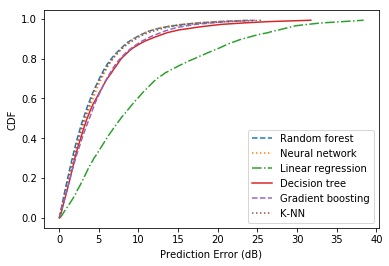

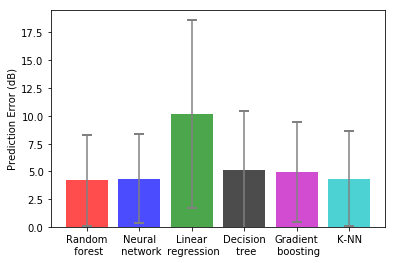

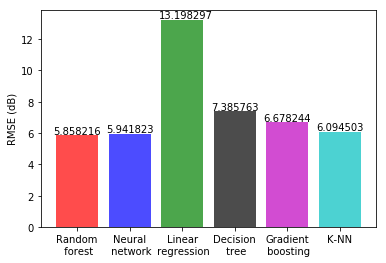

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import random as rd

objects = ['Random\n forest', 'Neural\n network', 'Linear\n regression', 'Decision\n tree', 'Gradient\n boosting', 'K-NN']
"""
# Real dataset
means  = [4.191894, 4.368361, 10.152151, 5.151650, 4.947673, 4.354931]  # rf, nn, lin, dt, gb, knn
stds   = [4.084162, 4.010076, 8.428471, 5.276139, 4.478879, 4.254475]
rmse   = [5.858216, 5.941823, 13.198297, 7.385763, 6.678244, 6.094503]
time   = [0.280681, 208.940886, 0.000600, 0.001238, 0.029086, 0.000590]
memory = [223.407500, 1680.747617, 214.925781, 215.144531, 214.632812, 215.431953]
cdf_rf  = [0.030394668539006488, 0.064223997263993762, 0.099004665254000909, 0.13470266620500723, 0.17087466255399661, 0.21299933272199867, 0.25129866727399502, 0.28166599945099252, 0.31578466604199451, 0.35204667130200562, 0.38712332637099661, 0.42527466693399363, 0.45903399946699008, 0.49631866663599938, 0.53537599921700429, 0.57013866376399558, 0.61126132930600263, 0.64574332873800477, 0.68118266726299448, 0.71657466466300268, 0.75331533323800004, 0.79105199919800373, 0.82880933612400187, 0.86721466700000105, 0.90472866603600122, 0.94660066683399979, 0.98350466496400757, 1.0235819984699959, 1.0575293304279993, 1.0935633315300033, 1.1402753373439949, 1.1779953317090066, 1.2137660010149989, 1.2541779982920096, 1.2915233307210019, 1.3274799933329819, 1.3738826671500066, 1.4167179986200029, 1.4527640034359997, 1.4935399986000084, 1.5362953341120125, 1.5767106652539959, 1.613603336580004, 1.6534853336799986, 1.6995726678570173, 1.7373833361580047, 1.7830806651199971, 1.8279306686780057, 1.86786400174101, 1.9091933343130123, 1.9566353328650086, 2.0006586700120006, 2.0456073349010064, 2.0937060015749869, 2.1341546687600021, 2.1718726676440023, 2.2207793359049988, 2.2708726691130035, 2.312041335727014, 2.3648273321749946, 2.4104813307410069, 2.4664846697190148, 2.5224766666879992, 2.5732473344429985, 2.6313953338480069, 2.6693240003030008, 2.7214593341789977, 2.7666706697879988, 2.8232100015880035, 2.878996671965997, 2.9470700012310034, 3.0030813325590056, 3.0703360021889989, 3.1272079981640051, 3.1856966701620069, 3.234466002125997, 3.2919000003019971, 3.3516813338189957, 3.4060580017709947, 3.4692979965520068, 3.5300020004630004, 3.5853193332030098, 3.6627706666060091, 3.7373806659969864, 3.7970013343469997, 3.8740233321029951, 3.9352906661969809, 3.9933566654559933, 4.053313329983002, 4.1364093313980019, 4.2095726677700132, 4.28878600231499, 4.3590213304350014, 4.4324233355089993, 4.5040326632640033, 4.596373332420999, 4.6841426651959992, 4.778245997804996, 4.8492879996460099, 4.9289819980720049, 5.0076213345529963, 5.0924339979329956, 5.1854706657019998, 5.2848760005589908, 5.357465997197, 5.447188661179994, 5.532090664059, 5.6343826654649991, 5.7280733318899877, 5.8470193311810057, 5.9541186653330058, 6.054118666589992, 6.1739899982990005, 6.3025206681170012, 6.4343186670020005, 6.5628993313419963, 6.7063453308320051, 6.8489719963619917, 7.0020686620950139, 7.1597953324549932, 7.3357746667709964, 7.5137993310259938, 7.7101060002139992, 7.8864293314809917, 8.0583059993309991, 8.2230726674760106, 8.4426099968609929, 8.6436286680880023, 8.914990002243, 9.2124106703649957, 9.4764066656360022, 9.8028639993900004, 10.142022666217004, 10.504326007641009, 10.873413337610005, 11.282387339999021, 11.828559337214999, 12.465029341244003, 13.284773335373004, 14.368998671504015, 15.637563999326003, 17.431640009419013, 20.041804006819014, 24.140507341608021]
cdf_nn  = [0.036539720629102275, 0.08003805621875032, 0.12387777649843798, 0.16356288922382717, 0.20332944070761713, 0.24575970373925743, 0.2841710829935542, 0.32512407911972646, 0.36330652300644628, 0.40473119446718797, 0.44841117678769576, 0.48980858919707049, 0.54105364004707057, 0.59100128383945416, 0.64243337207167983, 0.68049060864004007, 0.72607050415957053, 0.76792588088271441, 0.8165836640416011, 0.86908615982890536, 0.90646393467675845, 0.94807262703359385, 0.99299900292460963, 1.033817041516796, 1.0802286513282224, 1.1302882428771486, 1.174751238413672, 1.2118139388296878, 1.2544706343345708, 1.303314328827637, 1.338524390297851, 1.3764882828005864, 1.4243109107859369, 1.4710766076763679, 1.5108779048228516, 1.5506285274308595, 1.5945303776478519, 1.6368362789957041, 1.6717199452373053, 1.7136670649791013, 1.7522716531205083, 1.7922116888335926, 1.8329892452066394, 1.8712070683710942, 1.9194940202064459, 1.960601702179688, 2.0056764799519531, 2.0435672728986325, 2.0889220357902345, 2.1327163010384771, 2.17956952379707, 2.2308715974394531, 2.2715464604621105, 2.3221287409539073, 2.3746759979753906, 2.4242765545458975, 2.4756584346091786, 2.5241752765087897, 2.5814574851630856, 2.6351853117378896, 2.6923954245138675, 2.7364488577414061, 2.7956255940174812, 2.8547313361009752, 2.89957862428711, 2.9555565686851559, 3.007969532349998, 3.0624752190265614, 3.1267247997863272, 3.1670599570339859, 3.2236251854572253, 3.2907594622503895, 3.3426224915562495, 3.4055437324400373, 3.4554280187367197, 3.520410027276172, 3.5897346872322267, 3.6518068129246082, 3.7245448400775403, 3.7874719288328098, 3.8583036204859389, 3.9243900972964831, 3.9873317665470696, 4.0612497249912094, 4.1242036312917971, 4.1877317043601598, 4.2549068568492201, 4.3269064181972654, 4.3812383384310536, 4.4529360268527318, 4.5146228025849586, 4.5873627779593766, 4.6568816056062481, 4.7390890390871112, 4.8087542264351564, 4.9002316545837905, 4.9638603719248033, 5.0400909134169902, 5.1210163525689474, 5.201841208937501, 5.2866425381015638, 5.3798026687869154, 5.4626522865160174, 5.5402221448558597, 5.614383620615822, 5.7184178345479495, 5.8251604107964843, 5.9038617331570347, 6.008153287541993, 6.0928553934054674, 6.2029071154992188, 6.2972449552455041, 6.4245546571330081, 6.5501666280283199, 6.6639591586757829, 6.7747877508947285, 6.8846992726804714, 7.0395004387037101, 7.1705794920380841, 7.3130472970437506, 7.4655867785816374, 7.6405948023564427, 7.7973661093306577, 7.9525213491447229, 8.1207858990765622, 8.3324320472087887, 8.5429557959374964, 8.7982841928945277, 9.0391061937177692, 9.3150462481378842, 9.5777483287378917, 9.8283300893814456, 10.147772088221872, 10.450451306752345, 10.830854314034958, 11.257000890036812, 11.730325631260939, 12.342048790950983, 13.018453225078618, 13.999347563793753, 15.333997368934172, 16.905939066301169, 19.754916110024809, 23.777640603482411]
cdf_lin = [0.11573903750635452, 0.24307314420224016, 0.3688469834183577, 0.47477275840821664, 0.59058717094690294, 0.69644527752940388, 0.82255627539386467, 0.93732425690684773, 1.0653734281920213, 1.186165543942681, 1.2969355503120412, 1.4032198920040058, 1.5194102588916976, 1.6329114032356478, 1.7506707595871824, 1.8514952574215864, 1.9394167343593995, 2.056090757586158, 2.1360345261273896, 2.2223029450296234, 2.3010552065384005, 2.4008688844644621, 2.4950739248849887, 2.5981556304873767, 2.6902199473837105, 2.7747446534757345, 2.8679657708812876, 2.942279771107418, 3.0255991872801253, 3.1244094772721009, 3.2030977369867184, 3.2786199085301062, 3.3603700867162036, 3.4474951430118699, 3.5360483576510808, 3.6287001727102268, 3.7051411097611022, 3.7949563390631367, 3.8920012783096065, 3.9888588075643145, 4.0929987248832989, 4.2003569533097771, 4.2964001705626993, 4.3805286044964866, 4.4941811083143159, 4.6276086852425253, 4.7362965642258397, 4.850168033679032, 4.9508496574107896, 5.0638087641028013, 5.1762221260271586, 5.2842030587683135, 5.4045905315342067, 5.5100304496509436, 5.6055263885368571, 5.7276800263467429, 5.8268381582604993, 5.9304541262613553, 6.0486188556964331, 6.1630614951532303, 6.2775145942267532, 6.4004080771679863, 6.5191414686263691, 6.6564656309129244, 6.7754123106511095, 6.8862146860223961, 7.0356195473910184, 7.1482092660075889, 7.2799660570377727, 7.387191289265445, 7.533975339804595, 7.6649529140249841, 7.7768717386507369, 7.9083933104548985, 8.0605456048730488, 8.2083253191073613, 8.3581047192790585, 8.5140658937978078, 8.6343963960983725, 8.7981117308881345, 8.9289234350463627, 9.0782996349147886, 9.2136585817802388, 9.3543701013959133, 9.4983266702983524, 9.6583918512835645, 9.8184973071503983, 10.000245971955797, 10.140654285357828, 10.27694062134838, 10.434758846279344, 10.606801853865399, 10.77332693994342, 10.960855822516343, 11.139365463739152, 11.289769864831182, 11.464549725634152, 11.628721341816485, 11.795750830353949, 11.987073634158405, 12.209927866214329, 12.394565278440497, 12.623297422241583, 12.921088351117941, 13.174470926006268, 13.392835164215404, 13.758473674700836, 14.053879088565274, 14.390266273041197, 14.764926053975401, 15.073277542472919, 15.450822664485537, 15.8075454411495, 16.169142935730857, 16.539328325502559, 16.979826488799628, 17.351698393938999, 17.736762957098264, 18.187331795499151, 18.549159532678338, 18.981487558451292, 19.413886624205354, 19.833884859232363, 20.242765345863869, 20.60663158106027, 20.993530196870253, 21.391764472064509, 21.871571774672812, 22.370997370035102, 22.818277329333085, 23.430221969023975, 24.076272130182847, 24.714861948435342, 25.434256898596189, 26.327127102319636, 26.920161237387614, 27.720756378932979, 28.408521695321269, 29.064021273102249, 29.820636771399027, 31.327069342235273, 32.976118735978929, 35.628968996024611, 38.398648633214698]
cdf_dt  = [0.048133326499998789, 0.11186665719999553, 0.17266666269999745, 0.21573333410000062, 0.27366666269999923, 0.3160666574999999, 0.36746666239999937, 0.41826665839999966, 0.46099999320000024, 0.50779999730000036, 0.55626666150000004, 0.59986666360000063, 0.64606666400000079, 0.69333332989999941, 0.74113332609999916, 0.78113333440000121, 0.8355333339000004, 0.8824666624999995, 0.9244666648999994, 0.96439999970000168, 1.0067333309999993, 1.0551333282999982, 1.0993333304000006, 1.1403333316000002, 1.1902666641999993, 1.239266668700002, 1.2840666621999992, 1.3205999971000011, 1.3695333279999999, 1.4096666721000028, 1.4577333369000025, 1.4959333348000023, 1.5384666663000004, 1.5709333356000017, 1.6147999989000004, 1.6508000047000035, 1.6907333334000014, 1.7314666699000008, 1.7651333407000032, 1.8089999953999989, 1.8461333372000006, 1.8959999995000019, 1.9426000055000003, 1.9855333349000017, 2.0334666668000017, 2.0800000009000015, 2.1303333370000015, 2.1700666684000027, 2.2163333356000026, 2.2628000068000023, 2.3060000018000024, 2.3586000029000007, 2.4156666703000034, 2.4786000051000001, 2.5330000046999999, 2.5830666668000002, 2.6494666703000003, 2.7056000005000005, 2.7483333380000015, 2.7990666703000007, 2.8504666699000007, 2.9043333402000018, 2.9549333389000001, 3.0056000033999997, 3.0662000006000003, 3.1265999991999989, 3.185533334900001, 3.2489333334999992, 3.3059333313000012, 3.3611333314999978, 3.4113999930999985, 3.4641333342000014, 3.5407333279999973, 3.6065999983000006, 3.6762000007000015, 3.7419999956999992, 3.8005333295999986, 3.8739333330999979, 3.9553333260999968, 4.0293999937999985, 4.109599993999999, 4.2021999964999992, 4.2673333273999985, 4.3480666669000003, 4.4570666638000001, 4.548933331799998, 4.6505999952999977, 4.7346666670999973, 4.836066663099996, 4.9339333322999996, 5.0051999958999955, 5.1087999963999993, 5.2109333346999973, 5.3077999990000002, 5.421533325299996, 5.4991333322999933, 5.5867333299999959, 5.6928666695000008, 5.7804666622999967, 5.8860000044999969, 6.0044666639999953, 6.1019333350999965, 6.2286666651999978, 6.3569333376999975, 6.4757333359999993, 6.6092000016999926, 6.7150666667999985, 6.8214666650999991, 6.9433333315999937, 7.0898666627999969, 7.2152666618999977, 7.3321999970999991, 7.4542666639000004, 7.5592666667999993, 7.6847999965999962, 7.8221999993999987, 7.9672666630000002, 8.1644000023000007, 8.3467999970999998, 8.520933335099997, 8.6883333287000042, 8.8778000009999989, 9.1150666696000027, 9.3329333334000015, 9.6255333344999983, 9.903200002200002, 10.204466666399998, 10.532133332000003, 10.862266667000002, 11.282133331599999, 11.7318666675, 12.169066670699998, 12.6550666711, 13.145933338599997, 13.619733330200006, 14.342200004100004, 15.121266669300006, 16.35386666929999, 17.478400003200004, 18.910466671999995, 20.465666666799994, 23.114533339899996, 26.3592000031, 31.736666676299997]
cdf_gb  = [0.046194996724912014, 0.10062134870372802, 0.14987639790219817, 0.1975327063936706, 0.23832212043136636, 0.28144640447846297, 0.32600158032682486, 0.37473430055454687, 0.42184333510978889, 0.46825138694756491, 0.51391506222121375, 0.55229428250354473, 0.60763602132172867, 0.66875004683451866, 0.7098862993018612, 0.75594085271893063, 0.80326299108420929, 0.84915029913155959, 0.89400189371489813, 0.93935942313646148, 0.9846412316728923, 1.0324208614226691, 1.0827927594663691, 1.1256691455864525, 1.1727042886380823, 1.2158670685213608, 1.2650633578055162, 1.3111541927627939, 1.3511326987852368, 1.3996267791658723, 1.4487472635623937, 1.4984324762149357, 1.5373265640358893, 1.5868337135278332, 1.6330923852991135, 1.686406205755709, 1.7340976227902212, 1.7858556786314141, 1.834232875563357, 1.8913612575096175, 1.9374796462849557, 1.9950052803942671, 2.0395677799842127, 2.0926991904046379, 2.1390971474338749, 2.1879691073101246, 2.2370121412706125, 2.3044987466500171, 2.3627841199349593, 2.4205163269149348, 2.4764838192202165, 2.5334334161484118, 2.599237780799537, 2.6600180996196423, 2.7106089206198534, 2.7579312170230166, 2.8113169035414303, 2.8687324575626865, 2.920276180808512, 2.9805127745796756, 3.0461011459867775, 3.1020402423558888, 3.1634692201968573, 3.2325933506366038, 3.2946603687091112, 3.3612004655693921, 3.4215375033435032, 3.4882154489963177, 3.5571750206726178, 3.6237569454060257, 3.6926273551665658, 3.7605787550480545, 3.8286467783380611, 3.8937149789355954, 3.9682434102439199, 4.0259143340911718, 4.0840911405024904, 4.147372234649648, 4.2055088869772241, 4.2801792963200613, 4.3434018797434302, 4.4167335263137284, 4.4773612663338938, 4.5385470123391638, 4.6172240564544804, 4.6988656789220205, 4.7821267679099986, 4.8549744835888804, 4.9292971824062901, 5.0085083750876098, 5.0803253425596751, 5.1606820426895217, 5.2416049945308192, 5.3324005517800739, 5.42155577092639, 5.4979181453044408, 5.5808954342726125, 5.6680059481963712, 5.7547558338339506, 5.8464918846329734, 5.9393598228534419, 6.0258538780281672, 6.1300652370665514, 6.2400763200531992, 6.3359258324795436, 6.4534026727777025, 6.5583995498388097, 6.660235072931064, 6.7544494506444721, 6.8739114561979351, 6.9896749185102003, 7.1014961292959837, 7.2325904856018601, 7.3808347118422128, 7.5069001134648792, 7.661134679484408, 7.8335250373333363, 8.0014423032656374, 8.1630929868589206, 8.3187616891098557, 8.4974372258288557, 8.7264314893546029, 8.9368764338031319, 9.1558149923470165, 9.3756083121029654, 9.6470837878521571, 9.9035511058155183, 10.171246313894848, 10.473341164849888, 10.811698066457488, 11.186713113558286, 11.512755101366409, 11.90949220367736, 12.382336410840072, 12.810088900360329, 13.242102468277423, 13.804180595751776, 14.355573840325071, 15.107828102604628, 16.116751491054245, 17.211120117575277, 19.110768103660394, 21.223976505576044, 24.690004110521045]
cdf_knn = [0.047955557466668922, 0.090866667000001233, 0.13244444523333571, 0.16851111269999805, 0.20673333776666922, 0.24106666539999794, 0.26837777866666729, 0.30255555626666691, 0.33811110816666601, 0.37339999780000055, 0.40808888516666625, 0.44375555386666721, 0.47351111263333351, 0.50844444366666597, 0.55162222223333413, 0.59184444703333372, 0.63251111753333433, 0.67600000423333473, 0.72364444576666576, 0.76880000039999841, 0.80973333583333429, 0.8487999981333314, 0.89497778013333407, 0.93751111376666363, 0.98066666776666511, 1.0183555564666646, 1.0585111052666627, 1.0990444413999965, 1.1355111012333279, 1.1719999999666653, 1.2139333300999984, 1.2583111089999981, 1.3030666657999956, 1.3393111109666638, 1.382511107799997, 1.4279111108999973, 1.4644666659999996, 1.5015111087666642, 1.5448444419333316, 1.5902222206333319, 1.6333555570999989, 1.6785333318333318, 1.7229333305333312, 1.7629111132333346, 1.8090222197999992, 1.8541111119000016, 1.9029777756333317, 1.9440888866333323, 1.9885111114666671, 2.0403777766333309, 2.085066666933336, 2.1325111064666671, 2.1745555554000013, 2.2194666663999993, 2.2711999962666654, 2.3132888848333351, 2.3555777756000023, 2.4079777770999997, 2.4615111079666674, 2.5128444444333327, 2.572111111066667, 2.6228444437333343, 2.6778000023333353, 2.7206888879000006, 2.7684000000999989, 2.8125111133333349, 2.8704444487333318, 2.9256666656333334, 2.987199999933333, 3.0343555557000017, 3.0885555573333341, 3.1393777780333325, 3.2002222242333356, 3.2668000020666672, 3.3294888874999979, 3.3983333340999993, 3.4639999998999982, 3.530999997033331, 3.5888444406666644, 3.6492666640999971, 3.7084222162999971, 3.7600666678000003, 3.8183777765666651, 3.8773333271999979, 3.9286888912666642, 3.9896666693333329, 4.0518444382666647, 4.1083999973333309, 4.1776888842999975, 4.2340000000333342, 4.3032666658333332, 4.3701333318333306, 4.4457777745333349, 4.5263111126666651, 4.5976666671666662, 4.669844443999998, 4.7657333323333324, 4.8374222218333323, 4.9260888872666664, 5.0134444472333319, 5.1181555532999967, 5.2026444469999982, 5.3119777771000001, 5.4031333310999994, 5.4954000003333316, 5.5990666642333338, 5.6956000007333296, 5.7984222187333305, 5.8963555543000021, 5.9861111101999969, 6.1032222189666676, 6.2101999995333346, 6.3454888861666641, 6.4653999966666662, 6.6140666655000011, 6.7567111097999986, 6.8741777770999999, 7.0164222225333353, 7.2075555522666654, 7.3578666663666672, 7.5350222226333328, 7.6826666664666661, 7.8449333358000057, 8.0639111115000013, 8.2438000016000075, 8.4913777796333303, 8.7236888895333351, 8.9646222250333309, 9.2654222216333366, 9.5378666713333384, 9.7932444445666658, 10.075533334533334, 10.409088889866661, 10.825666668233334, 11.267066669600004, 11.77066667003333, 12.410311115799994, 13.033311116566667, 13.701777783699999, 14.734666674666675, 16.071866670633334, 18.291200006966665, 21.3426666758, 25.613422239066679]
"""
"""
# Simulated dataset: 1st
means  = [0.682037, 1.033564, 2.494174, 0.864544, 1.021797, 0.652020]  # rf, nn, lin, dt, gb, knn
stds   = [0.860200, 0.632278, 2.144597, 1.144290, 1.294116, 0.761810]
rmse   = [1.099699, 1.236445, 3.291103, 1.437248, 1.651104, 1.004637]
time   = [0.258571, 370.020720, 0.000716, 0.000914, 0.028463, 0.000385]
memory = [218.131250, 1574.052891, 217.125000, 212.960938, 214.910156, 216.250000]
cdf_rf  = [0.0041043159100115642, 0.0088371562694284471, 0.01339702605323282, 0.017745751037550973, 0.022450896794395162, 0.027134148265705278, 0.031633169321630988, 0.036362830638163215, 0.0402112095994255, 0.044856316746802918, 0.049744365664441688, 0.054365761437159821, 0.059297960853673712, 0.06372372843280999, 0.068947032766405417, 0.073644246818043088, 0.078037666957459784, 0.083674743083748671, 0.088024420620256477, 0.091839746401590081, 0.096570692380900172, 0.10246760967872603, 0.1079836407686085, 0.11261239796421706, 0.11791253194337699, 0.12242251592011456, 0.12831693281791487, 0.13403449024541672, 0.13912066818795496, 0.1429590960947148, 0.14877450775093309, 0.15321040853492093, 0.15826636451238771, 0.16313053998521837, 0.16781685263151502, 0.17311041183051998, 0.17920115241701681, 0.18427303873745104, 0.18903276384054549, 0.19542504460506052, 0.20045909783819255, 0.20641839535983864, 0.21229765245790602, 0.2185171534992105, 0.22455738430396976, 0.2306387926199156, 0.23601760485153861, 0.24125324033163564, 0.24659395707609832, 0.25261922052147584, 0.25910335659027339, 0.26486756739959533, 0.27067563860790655, 0.2765788621665668, 0.28262246291047133, 0.28904502987714425, 0.29504789372789941, 0.30231040776755874, 0.30811022460785226, 0.31447544218644469, 0.31987648129529928, 0.32660671417942666, 0.33336563358247218, 0.33996031245309555, 0.34728170247793289, 0.35412475789250109, 0.36081579239570588, 0.36786842926319552, 0.3759456257961416, 0.38412709605087569, 0.39233121258388903, 0.39990515912586844, 0.40667487540343472, 0.41467481250462584, 0.42259576591787834, 0.42991862950177961, 0.43850860318305734, 0.44640618105360585, 0.45442323779093952, 0.46392989602445184, 0.47132952569665987, 0.4793205533058324, 0.48620554227631629, 0.49650055786984582, 0.50602491164144892, 0.51543179718433796, 0.52454861923425045, 0.53491066379682284, 0.54601816685861837, 0.55656887481323436, 0.56766194559855976, 0.57967722226245011, 0.59144039759228562, 0.60146201433990698, 0.61552204765392371, 0.6286396136589848, 0.64347990902643748, 0.65818349119378594, 0.6724311045931981, 0.68526527371467039, 0.69804692314135763, 0.71200504337863879, 0.72800628466083017, 0.74087440215721567, 0.75824554575833392, 0.77240522713495896, 0.78846443246792308, 0.80763555274609289, 0.82726478517250523, 0.84950970118308855, 0.87141504563971706, 0.89108119262652163, 0.91462128442312374, 0.93804534469864298, 0.96458969006302364, 0.99550676837261975, 1.0211724392058226, 1.0492350666837309, 1.0799213693043721, 1.1167448756173184, 1.1495513701267817, 1.1899102886073583, 1.2315118337211215, 1.2749153963631203, 1.3298148217899943, 1.3800255906191052, 1.4393250285953259, 1.5022281192037144, 1.57298367841892, 1.6502998970942286, 1.7205502146020519, 1.8059749827623108, 1.8782614429929152, 1.980326386304037, 2.0859217092304889, 2.1884040574615375, 2.3222578322978622, 2.4857282723205767, 2.6810235791372135, 2.8997237125377251, 3.1610042721263283, 3.5872498182836261, 4.2631019586783694, 5.7615915019415231]
cdf_nn  = [0.056852649702733654, 0.10842986218943722, 0.14184684872205439, 0.1805525023076413, 0.21193705367365667, 0.2423334703234451, 0.26733516500891341, 0.28927028928090565, 0.31402167413371901, 0.33577841127000851, 0.35575005861078268, 0.37415196083118718, 0.39194964571522717, 0.4078274380895236, 0.42106668080583631, 0.4336361133285786, 0.44880573317590661, 0.45949401499191239, 0.47189131204183565, 0.48559376481898342, 0.4949604353653132, 0.50821857163608608, 0.5184409650759052, 0.5278987279939773, 0.53841984227625661, 0.54929572461915788, 0.55803665621294707, 0.56708262335506165, 0.57651424122443695, 0.5854325482058671, 0.59460098881790713, 0.60292116949711638, 0.61149624295084404, 0.62028335560646852, 0.6272780914545012, 0.63659701346107023, 0.64517701076318079, 0.65439046486823349, 0.66293761047658606, 0.6709191572869454, 0.68017340716711716, 0.68992870307960175, 0.69701555004660021, 0.70519618010672691, 0.71356337319635099, 0.72087928694710912, 0.72802693750463376, 0.73615879776317084, 0.74312100665698533, 0.74946587879377347, 0.75827233429002394, 0.76558010639160923, 0.77352894947460971, 0.78171507216463976, 0.78938010298453831, 0.79686066275985767, 0.80585872467061737, 0.81417350972513336, 0.82240836184584443, 0.83035960017130506, 0.83686259384457007, 0.84361487177553907, 0.85140428777290733, 0.86109325025928118, 0.86891774084187534, 0.87556546988831219, 0.88445546897921001, 0.89301661564314894, 0.89993172967849289, 0.90866329758898456, 0.91707809112788341, 0.92553978188024222, 0.93380867439489834, 0.94116153236422617, 0.94909487904617162, 0.95828085713457023, 0.9680006364772733, 0.97702757787735151, 0.98680745838561779, 0.99423573682230415, 1.0005763527070155, 1.0087642340852498, 1.0172713336971253, 1.0251054955209526, 1.034695386258877, 1.0418929938034678, 1.0500332596116884, 1.0586754483826015, 1.0667664465380466, 1.0767623249437821, 1.0835184343040156, 1.0907972513467887, 1.0981760830620155, 1.106868569054001, 1.1170909739140717, 1.1273777618215701, 1.1374220984569607, 1.1474353425231798, 1.1566409538166496, 1.1697571759890784, 1.1814267246846013, 1.1945361410196176, 1.206237058353727, 1.2182689231239856, 1.2314453867974762, 1.2420927937345616, 1.2548108832171101, 1.2659126833863832, 1.2827490542889137, 1.2929023556772881, 1.304712006792891, 1.3168944428829139, 1.3326774416536964, 1.3461869572597491, 1.3638991904002031, 1.383446522529195, 1.4015068350147037, 1.4164720528174677, 1.432795565215728, 1.4503813294299461, 1.4672502019340792, 1.489103842901373, 1.5101009616976018, 1.5327415554126793, 1.556521473374844, 1.5854204550344617, 1.6070146814601964, 1.6373092045000219, 1.6735857083041175, 1.7121927631206553, 1.7549820599555404, 1.8009488101189288, 1.8489230476291549, 1.8979029577650695, 1.9701250254775471, 2.0493711224958515, 2.1357143199630091, 2.2403834784107728, 2.3642451781375615, 2.5445016264484988, 2.7320069209224682, 3.0549873200879882, 3.4494044085476521, 3.9578738750191031]
cdf_lin = [0.024152292353117701, 0.048995360798516997, 0.075604680130751375, 0.10210919484159958, 0.13005776207824651, 0.15464300316362625, 0.18154037338725415, 0.20257406044814516, 0.22610693078604938, 0.24859623618865201, 0.27687207698524818, 0.30353027101053542, 0.32888867513362813, 0.35860136259159714, 0.38581408766384173, 0.41740575129342872, 0.44177472703093712, 0.47261467083591185, 0.49989870517858931, 0.53013834390454562, 0.55749346004141376, 0.58505738610368496, 0.61506606396538321, 0.64381984065897147, 0.6707660334516875, 0.6951857006352623, 0.72409720543740974, 0.75216293917310506, 0.77789331899702863, 0.80278837094100863, 0.82845519602715822, 0.85611707043116159, 0.88322211948023099, 0.90806787845025339, 0.9343653227503953, 0.96332563292024986, 0.99117628427699989, 1.0146481190474634, 1.0375624181644849, 1.068687360240969, 1.0917564848010142, 1.1181853655434089, 1.1458509038668512, 1.1721630568012251, 1.1982742231206398, 1.2236173137841551, 1.2556476826443133, 1.2880163200559269, 1.3151605384457401, 1.3420314025840288, 1.3716807452949649, 1.4018992657668117, 1.4267992083678893, 1.4569785198702232, 1.4871222620614279, 1.5203059158041135, 1.5498143876387518, 1.587550846369141, 1.6202187970835005, 1.6518427019658473, 1.6892461173333893, 1.7269741506583682, 1.7610242519899981, 1.7962039736593771, 1.8316436099347868, 1.8667744432523119, 1.9042081821795869, 1.9480795009810798, 1.9794884600017928, 2.0158390567952824, 2.0529455154311189, 2.0773592730992418, 2.1096379056270718, 2.1410852583775908, 2.1740020840815051, 2.2044304798355139, 2.2364743299149588, 2.2651065537409933, 2.2938436921313543, 2.3248564967104892, 2.353029107492917, 2.3880444012765394, 2.424937662898766, 2.4555800178058642, 2.481398634181736, 2.5176105339022103, 2.5454953184976032, 2.5725554810725439, 2.6023721306991137, 2.6321891796135386, 2.6668333515669111, 2.7036785302241224, 2.7345741567911888, 2.7698376627004775, 2.8016730146237037, 2.8349746086642553, 2.8713156437638054, 2.9055559273157781, 2.9422804587165898, 2.9843690382969696, 3.0181077467566593, 3.0585360760315656, 3.0917536073655123, 3.1363698863709235, 3.1756597774615853, 3.2213891313301297, 3.2680071323365025, 3.3103640776535972, 3.3511001421478444, 3.3928064055845728, 3.4453014494675092, 3.4918228730159546, 3.5361320469238509, 3.5809188088167092, 3.6219402048514793, 3.6787978283515379, 3.7233016375483339, 3.7736220956078359, 3.8230957565638177, 3.8797863206475638, 3.9456294476335372, 4.0308725082227124, 4.1144721090936578, 4.1842754894200525, 4.2801985314170494, 4.3820064360073809, 4.4925291921132064, 4.6382672351596668, 4.7636023856456635, 4.9105007059919012, 5.0561171832450391, 5.2132906747000103, 5.3962867898952194, 5.5983885234389952, 5.8685802396774864, 6.1543309833719135, 6.5259505984653723, 6.8857248881417616, 7.5703255011856116, 8.2351221594165764, 8.8642556667820003, 9.7779128521685532, 10.980309978220403, 12.181002854285889]
cdf_dt  = [0.0030253200839970872, 0.0068461790459987525, 0.010853375369996315, 0.014677720809999073, 0.018617738957997575, 0.022781292761998771, 0.027321167698000862, 0.032744124949001335, 0.038459597223000373, 0.04401324674400129, 0.050106539015999235, 0.055832347309000024, 0.061888429391001407, 0.067128789089998975, 0.071828697124999646, 0.077293468861001025, 0.082235611737000489, 0.086686909979999033, 0.092305864630999532, 0.097675186206997749, 0.10406626569799798, 0.11037702094900141, 0.11624068618499848, 0.1216845047359989, 0.12725741294700144, 0.13440449638899993, 0.14241115138199889, 0.14961328150800043, 0.1571340628279998, 0.16416981948099918, 0.1723972230889993, 0.18124379015400024, 0.18862836185100065, 0.19643241080099927, 0.20497086908100015, 0.21322184554700144, 0.22165263369200106, 0.22925412098500203, 0.23721373172700083, 0.24410346214500023, 0.25245396168999934, 0.26025488796150187, 0.26726551258800041, 0.27329131683799845, 0.28129340764599947, 0.28932453852199913, 0.2968909361060017, 0.3050078535794985, 0.31265936986800014, 0.32187150781399881, 0.33140111345600004, 0.33864294735500056, 0.34701982566199985, 0.3559603408390008, 0.36367824582500119, 0.372158131251, 0.38016255186000109, 0.38846255109799954, 0.39730596683850211, 0.40545992331500103, 0.41369449978049871, 0.4219667867525001, 0.43029068786449998, 0.43814947204100052, 0.44733323534349878, 0.45612655400149849, 0.46460991155849996, 0.47341242576399734, 0.48285941252299963, 0.49292215551299934, 0.50147402569299937, 0.51001681988199876, 0.51903093851699955, 0.52837465767900094, 0.53820542403049954, 0.54802597412900167, 0.55693693956350099, 0.56829733196150001, 0.57944275791900113, 0.59126985460500203, 0.60175549442700027, 0.61435117698000186, 0.62778687696600111, 0.64063683400400118, 0.65196951899000044, 0.66333816134900248, 0.67464384635099972, 0.68608814029300103, 0.69794593561550244, 0.70944154431600093, 0.72269726622100139, 0.73512742840300105, 0.74913023257500255, 0.76429488173850135, 0.77915156935200092, 0.79285322633899979, 0.80868893056349889, 0.82265370829100282, 0.84037025002500076, 0.8576104344140022, 0.87309270164300201, 0.89162012490800047, 0.90965151653400311, 0.92690012656900056, 0.94857610132700076, 0.96857715489300078, 0.9921272990190001, 1.0159681903420015, 1.038751659816, 1.0596643849730001, 1.0870699904060019, 1.114580068135, 1.1438210645579994, 1.1742972601720021, 1.2062557030210004, 1.2365890694539978, 1.2674583137220004, 1.3043299227510017, 1.3471726269509998, 1.3884986768449996, 1.4255046404910001, 1.4646294518849994, 1.5137070512629998, 1.5646538524759996, 1.6133551625499996, 1.6698667464885, 1.7281161818379984, 1.7792952676460003, 1.8423997377070009, 1.921711178694, 2.0192709179709998, 2.1412802247839964, 2.2608365946219999, 2.3989364141479985, 2.5618611183390003, 2.7332723318529979, 2.9463682273799994, 3.2045678453139987, 3.5159065958170004, 3.8680475121290003, 4.4185190000840002, 5.0171054252979994, 5.9785534050120006, 7.6891732063389986]
cdf_gb  = [0.0066813264042384904, 0.013796353149756016, 0.021703134712386146, 0.029539782950368191, 0.035499829325136713, 0.043201414359976979, 0.049974048257216026, 0.056212529156782549, 0.063836319161195407, 0.070409038469432653, 0.077834397577375966, 0.084523247972395132, 0.091281491345653484, 0.098264877471857512, 0.10457520870787348, 0.11180431647332129, 0.11896592343532646, 0.12627646739286547, 0.13223013902097605, 0.13851202599695001, 0.14509842315416732, 0.15176918645474402, 0.15992451806998489, 0.16655706910250884, 0.17329108868175866, 0.17994303505528478, 0.18912525861977728, 0.19519972261081037, 0.2022205000401962, 0.20959784956031954, 0.21638754549048086, 0.22356535190521343, 0.23038001116410498, 0.23746630156921328, 0.24543459115173946, 0.25250950636983999, 0.26002671569225411, 0.26640556667416787, 0.27430892257854056, 0.28176396718178992, 0.28843589562483701, 0.29585530537085575, 0.30417400792805893, 0.31246283848598283, 0.322384963603149, 0.3300025951528846, 0.3382823927026084, 0.34663325253391802, 0.35592104409548114, 0.36386490035266733, 0.37396669853030162, 0.38233763558690481, 0.39264298087066363, 0.40079647126918971, 0.40996168733603766, 0.41799437774383091, 0.42678929767181456, 0.4346275949168934, 0.44344025578119284, 0.45237395374216077, 0.46200770330745528, 0.47281819486793453, 0.48621263506075435, 0.49519607184128062, 0.50625232354737293, 0.51537556442830279, 0.52538455296376574, 0.53675572745134925, 0.54825199596158602, 0.56012266932018606, 0.57051737967483918, 0.58140156767569062, 0.59306090809127765, 0.60487840434948847, 0.61586581335941493, 0.62795037998471503, 0.6405580413718962, 0.65280355690288816, 0.66502737148547031, 0.67980436060449123, 0.69213988926256287, 0.70387047917716528, 0.71831244410584205, 0.73326982905223237, 0.74987282057068527, 0.76479464575508604, 0.78037444079276452, 0.79670452867321684, 0.81191696668777824, 0.83136206589936479, 0.84746475012443001, 0.86425867919302901, 0.87998784683194076, 0.89974697094063638, 0.92034624568062595, 0.94337749220168232, 0.96387097056429727, 0.98621841511158392, 1.0070260169366927, 1.0330006976693118, 1.057453443471787, 1.0794673810863862, 1.1066845970761896, 1.1377041438553037, 1.1670167955204711, 1.1932362977905451, 1.2210280226875938, 1.2500553969821933, 1.2786907484207233, 1.3088900008872013, 1.3417877085455365, 1.3711433801058188, 1.4037395178026901, 1.438641290186665, 1.4722409313843059, 1.5071438412159781, 1.5441497734716938, 1.5859242097789041, 1.6262749801866982, 1.6746953116773142, 1.7245632814136684, 1.7805111365649651, 1.839620596125974, 1.902005451418523, 1.9607420175438461, 2.0284899762595017, 2.0971765135138192, 2.1724279465120291, 2.2504889502580463, 2.3623694342894419, 2.4931938848607227, 2.6133643822834385, 2.7267989378890776, 2.8970685963168963, 3.0648462289184675, 3.2945938333706604, 3.5363878834520079, 3.7467874624311763, 4.1281663569171148, 4.5600978982319589, 5.1436191735428585, 5.9204263337963869, 6.6712351295307233, 8.0606312175600969]
cdf_knn = [0.0054731875530016792, 0.010781285043666173, 0.015782620747331891, 0.020797727543998831, 0.025938576418667054, 0.031351642020667328, 0.035512904948000565, 0.041287475991333908, 0.046540565396332598, 0.051712173147999321, 0.056046993422333033, 0.061286884728334455, 0.066695194110001091, 0.071448866275332673, 0.076553391618998462, 0.082439817038002447, 0.088609032399667026, 0.093274935356333799, 0.097914680647332511, 0.10378966701999928, 0.10815830095766771, 0.11280257611333326, 0.11837937255500081, 0.12295925360200073, 0.12808161144433441, 0.1332967000563339, 0.13873932197400093, 0.1440066824116677, 0.14869053319199976, 0.15346793172999895, 0.15808057783899984, 0.16225877716700182, 0.16738769281100033, 0.17246143853533283, 0.17746238179366544, 0.18275301707966476, 0.18813709862266478, 0.19371759986433232, 0.19871980485099955, 0.20438349942233103, 0.20921752053999726, 0.21508943759733185, 0.22133645776633146, 0.22763044203066529, 0.23365545352266637, 0.23886457781966441, 0.24565795792300008, 0.25148444673033254, 0.25602214136699769, 0.26328965566533258, 0.26875435729099623, 0.27516725577166495, 0.28194150804499912, 0.28813382981533264, 0.29476345729033154, 0.30243445525133322, 0.30883529791466485, 0.3169319954386654, 0.32309606051299822, 0.33051763797233363, 0.33657627275733248, 0.34439084839133371, 0.35157715342966767, 0.36047288424799701, 0.36664175507633445, 0.37327270158033327, 0.38013060420366601, 0.38764809460566707, 0.39574934922499877, 0.40397135489666636, 0.41134617790333378, 0.41878361095733441, 0.42782386317933319, 0.43519823327333357, 0.44374595546466722, 0.4517087674990013, 0.45868422267099862, 0.46718826038699945, 0.47606409426566515, 0.48593123580266662, 0.49496509050733167, 0.50236515686333139, 0.51096266509366672, 0.52012437961766655, 0.52904751666266658, 0.53869378308799865, 0.54908907828900044, 0.55858378037066514, 0.56780194839833253, 0.57933743793966697, 0.58919505587699961, 0.59978358172099977, 0.61056352725466567, 0.62304248168133158, 0.63412176871166748, 0.64482695870266771, 0.65746197099233117, 0.66984408450400068, 0.68507278100800095, 0.69694637522666691, 0.71327391527566575, 0.72561231305399954, 0.74055778272566553, 0.75543087344666715, 0.76911949350366771, 0.78675661362366778, 0.80170742104766557, 0.81672682737433333, 0.83508835285866778, 0.85383414322466422, 0.87590978742299785, 0.89207600075433446, 0.9146131494396661, 0.93696198487466698, 0.96242747393033401, 0.98478829847333171, 1.006904651969001, 1.0345072870663334, 1.0628183818133323, 1.0913007832370003, 1.1171590345136648, 1.1486235440293346, 1.1876392479603317, 1.223271458505333, 1.2575843659093324, 1.2972822672730002, 1.3369149522963333, 1.3772673342803343, 1.4205059224356653, 1.4754552895006676, 1.5246057112809996, 1.5855691754613348, 1.6410861750483323, 1.7041401815449995, 1.7844146764970004, 1.8762445837396657, 1.9878726976573353, 2.108320202636333, 2.2757062756546662, 2.4523562556173331, 2.7274730217666643, 3.1456440209889944, 3.8343223474493264, 5.3522167199619943]
"""
# Simulated dataset: 2nd
means  = [0.244246, nn, 1.290626, 0.319351, 0.284344, 0.250544]  # rf, nn, lin, dt, gb, knn
stds   = [0.260085, nn, 1.049927, 0.341190, 0.299279, 0.286083]
rmse   = [0.357097, nn, 1.664669, 0.467943, 0.413095, 0.380718]
time   = [0.232054, nn, 0.000606, 0.000929, 0.027083, 0.000354]
memory = [217.913555, nn, 215.066406, 214.916133, 214.429688, 218.890625]
cdf_rf  = [0.0018052501567022716, 0.0034827382485364921, 0.0050761448623082121, 0.0068667956061307222, 0.0086385033283069394, 0.010321277064135046, 0.012137145963167057, 0.014084022560630557, 0.015854500371193295, 0.017512828729355619, 0.019260430707264079, 0.021357599179018791, 0.022821938153319222, 0.025140645966876887, 0.02689044294728447, 0.028861935970374616, 0.030864175806828768, 0.032804149993330471, 0.034582415836208892, 0.036390924261952479, 0.038296680444422859, 0.040158575131234074, 0.042141297213621559, 0.044450010417919683, 0.046697850872563437, 0.048662600180374514, 0.050663874970440899, 0.052535050672054384, 0.054629600239190099, 0.056448477000794667, 0.058363481769744964, 0.06060994095350708, 0.062744191943347835, 0.064612845426299401, 0.066885983676875607, 0.069280011233915098, 0.071322060154110287, 0.073566281563877289, 0.075764390179979269, 0.077807341989642675, 0.079854837022776057, 0.081966214278001812, 0.084115625347355796, 0.08608566919981897, 0.088407082762477246, 0.090624203267209824, 0.092965016942211071, 0.095230887854162491, 0.097926131062435071, 0.10044933624470459, 0.10279050148542496, 0.10532194773932801, 0.10778883532942657, 0.10986495931442378, 0.11251675991416775, 0.1147951146476987, 0.11722148357373313, 0.12006120818222456, 0.12260272461989644, 0.12547652797233794, 0.12803358714676391, 0.13050689433204085, 0.13355131821981969, 0.13648702401686777, 0.13933317966543854, 0.14195670734183707, 0.14491716614609459, 0.14805550567134362, 0.15078587988746706, 0.15345869413414392, 0.15662660026339906, 0.15923241227826665, 0.16274767039466084, 0.16596864200347938, 0.16910089898751493, 0.17211697198434081, 0.17492240495893627, 0.17782977075332923, 0.18180214245733395, 0.18486369331604777, 0.18874554423318926, 0.19243276468716544, 0.19610220472198706, 0.19961783375302658, 0.20363099074467997, 0.20770056581078167, 0.21084235880314878, 0.21456514488215972, 0.21853888109372632, 0.2225024096742233, 0.22647065959708329, 0.23028897593829556, 0.2352822935711687, 0.23990922874294171, 0.24507130072142019, 0.24975986231675576, 0.25443865986391062, 0.25943699692777217, 0.26424669390839001, 0.27013230371601055, 0.2772433998954949, 0.28210837924392623, 0.28744904047185615, 0.29309933928994397, 0.29973103354757002, 0.30658090846454811, 0.312907887090426, 0.32023239421635397, 0.3270796026129979, 0.33372802237493304, 0.34221656316623128, 0.34934882427842368, 0.35730119119947218, 0.36444962557420568, 0.37332845908482215, 0.38038967416948039, 0.38844613392407112, 0.3973503691545669, 0.40630561544949317, 0.4162655585374368, 0.42667014796711045, 0.43764993969283139, 0.45111006321757513, 0.46454825620433454, 0.48033610827076983, 0.49358046681490053, 0.51100447929143844, 0.53004798216522386, 0.5525718115843361, 0.57210845453071724, 0.59985375025731036, 0.62375099069882856, 0.64340275573382033, 0.66781422871171459, 0.69749460466970359, 0.73265391255546786, 0.77690434422312071, 0.82194358648327481, 0.88115677877093701, 0.94431908378347884, 1.015159013231137, 1.1010855229044794, 1.2463105129552532, 1.4758537808049494]
cdf_nn  = []
cdf_lin = [0.014088827113087489, 0.02723822500805298, 0.042623342954702534, 0.055359188754021176, 0.069634557962008611, 0.080728850899737095, 0.094465571279314139, 0.10738106805801578, 0.12035605022326862, 0.13246470622800288, 0.14421384045709076, 0.15750354888537771, 0.17146586757759977, 0.18534426251920563, 0.19653468815642497, 0.20888359674216631, 0.22147446280248062, 0.23352290421512975, 0.24729215471522095, 0.25924870791761251, 0.27159856840088098, 0.28593868802896849, 0.29692307646636379, 0.31568843383001222, 0.3308224628241706, 0.34685183493505634, 0.35969017854236202, 0.37557697589290567, 0.38938663361688258, 0.40219460489255809, 0.41557222081350359, 0.43134812270523254, 0.44315240734414585, 0.45864976081881964, 0.47305111350556728, 0.48757999078437919, 0.50145337057938055, 0.51649682256260054, 0.53231441573285754, 0.54619704099356869, 0.56255864295191371, 0.57757750324776613, 0.59326944835689577, 0.60695191712933394, 0.61757552471964527, 0.63175705098775925, 0.64463669891307618, 0.65870343710123347, 0.67501926047825278, 0.68924999429855305, 0.70263460771190112, 0.7174322263093299, 0.73346655783818648, 0.74674019744314146, 0.76296485279398785, 0.77835058263218071, 0.79341754214349436, 0.80989645503109542, 0.82804292400599222, 0.84576036162644808, 0.86062893858127576, 0.87738040921272809, 0.8960069730043162, 0.91228460255942556, 0.93011774926269364, 0.94522228228763749, 0.96345084522176494, 0.97856571811996385, 0.99859296460275215, 1.0128788729863416, 1.0280678430407924, 1.0399164779918266, 1.0532939755266173, 1.0705793667769949, 1.088172588677137, 1.1043103503630507, 1.1187512014082193, 1.1362692433627237, 1.1506542436393068, 1.1669139483273454, 1.1838703233872339, 1.1999058749999834, 1.2173295381459157, 1.2318707790122907, 1.2465160750744595, 1.2615007349940206, 1.2820726415134762, 1.2990332079333411, 1.3157167810453092, 1.3326665241962081, 1.3499765174314087, 1.3690799953365813, 1.3900949797014182, 1.4106887224839317, 1.4317462550978328, 1.4522954063075466, 1.4753305462788293, 1.500244259155824, 1.5246888919908113, 1.5489821178430667, 1.5737317135679092, 1.5997656481958848, 1.6268453056857157, 1.6554422293788109, 1.68470018549509, 1.7110145336453155, 1.7454884304524443, 1.7721028297495973, 1.8011076001749546, 1.8351042003045064, 1.8633870146404516, 1.8960406843129443, 1.9274329055655905, 1.9609664702380412, 1.9925130338527117, 2.03276275494916, 2.0764828134257094, 2.1195110675248467, 2.1663094754513685, 2.2238769671217771, 2.2774928507394554, 2.3401221518891746, 2.3939881701265859, 2.4810060269223002, 2.5378322972331131, 2.5933100589724973, 2.6512691923579665, 2.7050244665206327, 2.7624417299906643, 2.8156768730616215, 2.8756023725597144, 2.941486609497828, 3.0037024772901977, 3.0743198910645488, 3.1558004476127413, 3.237648718386037, 3.3462919586964683, 3.4804500438870591, 3.6582416550379064, 3.8590346886224336, 4.0844241527217093, 4.3683436495581622, 4.701677697038309, 4.9584514434041118]
cdf_dt  = [0.0015661702429956392, 0.0029497045619990558, 0.0047046880310003302, 0.0064558204410022314, 0.0084097865990030128, 0.010568217619003662, 0.012683794380002666, 0.014730113975000734, 0.016891802363999772, 0.019366134571999823, 0.021851181136999714, 0.023881171926998662, 0.02638168271399877, 0.028951406877998097, 0.031112762621998656, 0.033407570668999825, 0.035694444581000087, 0.037508503244999221, 0.039628866318999485, 0.041498186229997597, 0.043656784136996835, 0.045948689507998776, 0.047704138610998828, 0.050008733098998309, 0.051938042541999609, 0.054489000734000113, 0.056876393364000251, 0.059116201381999786, 0.061643666699999503, 0.064022074550999689, 0.066139264993998387, 0.068415449200000325, 0.070982726629999882, 0.073040396281000147, 0.075079743563996576, 0.077708201056999826, 0.080642945677997069, 0.083420116164998462, 0.086272793569998785, 0.089218257420999689, 0.092416234194998739, 0.095659767470998386, 0.098815610121998104, 0.10161127297999997, 0.10476533226599855, 0.10805676799499991, 0.11102256878299883, 0.11470225126999836, 0.11857507349899848, 0.12192397148100027, 0.12531381007000036, 0.12827711981099868, 0.13162004537099833, 0.13483841677599956, 0.13814304829999982, 0.14178495401899893, 0.14558326746299927, 0.14888305161499929, 0.15257445794000049, 0.156493704560002, 0.1603850252700012, 0.16434786756100109, 0.16809797944700081, 0.1720536485000001, 0.17683635283600155, 0.18062885629500158, 0.18556530610900268, 0.189913818718002, 0.19382782013400018, 0.19784270023800019, 0.20273247054300142, 0.20681481796200188, 0.21178562019000055, 0.2163564097890007, 0.22123554192300118, 0.22605423230600125, 0.23090186419100037, 0.23580479666600185, 0.24090236588400074, 0.2457405735399999, 0.25138711463799879, 0.25669738073399984, 0.26317343898500029, 0.26806948291699956, 0.27400276247999938, 0.27912227722600008, 0.28471662043799811, 0.2899682890209998, 0.29639356840199982, 0.30220061175699953, 0.30824029696599753, 0.31419554208699862, 0.32000261390399942, 0.32692852266499939, 0.33296765490699998, 0.33943397094099781, 0.34641326904999842, 0.35376533275299865, 0.35988313258099736, 0.36545712407199704, 0.37352885157399757, 0.38048498563999628, 0.38812952507399728, 0.39553568952499957, 0.40440299360099929, 0.41243263601399888, 0.42199652836999846, 0.43106175939099844, 0.44148219794100013, 0.45163305030999951, 0.46176469057999897, 0.47209264407899826, 0.48170001342400026, 0.49323146301100096, 0.5046891154319979, 0.51761371970599956, 0.53252508334299975, 0.54414699253800181, 0.55872039900299886, 0.57409467299800065, 0.58598885879100082, 0.59955127466100067, 0.61838205923699974, 0.63456752318599863, 0.65417905723000092, 0.67499399519399983, 0.6959103746540003, 0.71669832176899873, 0.73577610367699819, 0.76034458940499861, 0.78476173396299953, 0.81015136667499887, 0.84336452134799744, 0.87982629678099966, 0.91835515843299886, 0.95456107206899798, 0.99774225814899864, 1.0561098886009992, 1.1125493502289994, 1.1833379489660012, 1.2722207643579997, 1.3825438411299991, 1.5801139087059985, 1.9367840724529986]
cdf_gb  = [0.00199617732684203, 0.0041502507458662311, 0.0060788011490876667, 0.0077723381388838672, 0.0098281113308908638, 0.011608241214174199, 0.013494658101783302, 0.015394699763895972, 0.01754542884041925, 0.019523371792613348, 0.021688008054732963, 0.023411169814517619, 0.025417992944868927, 0.027944807581785226, 0.030070804800214148, 0.032188047408652241, 0.034533119877555689, 0.036722814712056934, 0.038885464762003469, 0.041268875370652582, 0.043322101795198902, 0.04521096881336973, 0.047511696429218375, 0.049591397175323806, 0.051612537152720676, 0.053883427482097943, 0.056003264043673652, 0.058086893045362444, 0.060083470788896136, 0.06224087928687027, 0.064329033635663821, 0.066500890908359048, 0.068807426915124661, 0.071077131057608364, 0.073227942323442083, 0.075318625513112913, 0.077892281931216015, 0.080215056820180028, 0.082711486051346275, 0.08505341793624481, 0.087845617165788356, 0.090087842982290597, 0.092835852304946939, 0.095118281290436785, 0.097523351333153985, 0.10010985669760544, 0.1028462033812069, 0.10533274110602875, 0.10842387165326485, 0.11143689739927083, 0.11381503571872685, 0.11691402597554515, 0.11976826034030807, 0.12230517465060671, 0.12498443825599083, 0.12745764802862966, 0.13040362104240699, 0.13287949703552498, 0.13584366823452826, 0.13896991304512327, 0.14242989204241865, 0.14566415055638274, 0.14858025585246992, 0.15163371002260079, 0.15426761867218106, 0.1577225913504762, 0.16092141660562845, 0.16413393115100078, 0.16775181902077846, 0.17139678901680511, 0.17477091483785742, 0.17819523173898161, 0.18184109834973228, 0.18587837903107271, 0.18904457138476516, 0.19290160819987079, 0.19716385265359521, 0.20118928228539759, 0.20501798402193758, 0.20839686031549021, 0.21254775994548011, 0.2173063881228734, 0.2217078659393725, 0.22618156852289986, 0.23148446234478073, 0.23658381927839145, 0.24169356114454202, 0.24615220375823271, 0.251555515353451, 0.25648896401451199, 0.26232426523964819, 0.2676304013189913, 0.27237447159193806, 0.27823613849300743, 0.28481723048468327, 0.28976151796672239, 0.29590466350851841, 0.30238370679830168, 0.30950835404527838, 0.31611611127713601, 0.32316350536810373, 0.33192959356468749, 0.33960110041133335, 0.3481604345384024, 0.35591054177068782, 0.36482264120706021, 0.37392664092246064, 0.38193174224613502, 0.39297385667114992, 0.40152022980803154, 0.41323237253912209, 0.42193805191702621, 0.43318169438904491, 0.44445216167807372, 0.45605806482135292, 0.46778370373591954, 0.47925937086469345, 0.49201975209040782, 0.50635447568308967, 0.52265511953339883, 0.53708877270494515, 0.55204507559995464, 0.56599351274031717, 0.58290889374971444, 0.60353577547920179, 0.62025931669967949, 0.63606548075605895, 0.65318607461301592, 0.67254474315949209, 0.69709120184047846, 0.71747006439576777, 0.74480136675727104, 0.76702592124783886, 0.79157182503817936, 0.81641397753328537, 0.85359499757021762, 0.88903964533161584, 0.93818622097035598, 0.99100537981355885, 1.0611371785422476, 1.128887433013138, 1.2401693094105986, 1.3804913056313206, 1.6074125033789115]
cdf_knn = [0.001570130968335235, 0.0033800864516682337, 0.0054053729403331372, 0.0074196741566683495, 0.0095250372349980246, 0.011239797144333324, 0.012842266079000525, 0.014477264236001304, 0.015928701106666807, 0.017507051267667748, 0.019285552750667848, 0.021245974270669449, 0.023155967903334584, 0.024979106488999606, 0.026630318943667675, 0.028412048063666193, 0.03008360028299947, 0.032053497528665528, 0.033458217139999108, 0.035291292149333062, 0.037076883903332032, 0.03914044006833322, 0.040759300539999682, 0.04280026415566681, 0.044556906925666481, 0.046684374795666915, 0.048339181199333864, 0.050118869671666746, 0.052011539637666145, 0.053794237956665963, 0.055515172117332409, 0.057330620903998833, 0.05925939046566555, 0.060893897342333643, 0.062658774005667939, 0.064876748858330446, 0.066884549943664523, 0.068905373486667545, 0.071095252761665229, 0.073081045270331935, 0.075314963682332342, 0.077649192986331883, 0.079993964049665467, 0.082272208916000122, 0.084400951460333717, 0.087150602564332186, 0.089458885436332167, 0.091718686773001823, 0.093995096445665074, 0.096639580265333647, 0.098735842014000069, 0.10124465372833143, 0.1037806401346657, 0.10587474521333221, 0.10892798851066758, 0.11174927126700268, 0.11414552169033115, 0.11710306491766445, 0.11962958926300032, 0.12203737311433287, 0.12473299809500134, 0.12733931441399918, 0.12989987667200012, 0.13259617699699902, 0.13476113316733473, 0.13777316136933307, 0.14052825245933334, 0.14318841589999975, 0.14590138236766648, 0.149113958611334, 0.15213284610933372, 0.15481262354733233, 0.15787617877866494, 0.16094290118800003, 0.16430008219599984, 0.16802260836666591, 0.17134557339733392, 0.17478562909933332, 0.17766142156566589, 0.18147517839899976, 0.1849281032486661, 0.18862465771466788, 0.19311587177899966, 0.19704053625133069, 0.20113172192899981, 0.20512695594533256, 0.20890922003999876, 0.21318291004233245, 0.21747735920299932, 0.22137939655800026, 0.22622223348399914, 0.2306107490019994, 0.23448629950266522, 0.23899312727833263, 0.24331898634966551, 0.24801640293199995, 0.25271384069599917, 0.25777278338966636, 0.26260953912400054, 0.26777958071633423, 0.27276537052766697, 0.27947749714600079, 0.28728820248933346, 0.29267813053666641, 0.29849351061433393, 0.3046471667486661, 0.3133793938489991, 0.31976906095833257, 0.32658922244633187, 0.33424199375866548, 0.34258477984533142, 0.35042130301433233, 0.35815314444699964, 0.36792328582399875, 0.37715899301799793, 0.38620803428033357, 0.39524615402333352, 0.40503987104999994, 0.41460430312233415, 0.42620454099966737, 0.4375698979639992, 0.45009182579666773, 0.46308136895600227, 0.47688127633166588, 0.49081043558366544, 0.50554071403166434, 0.52261838824666673, 0.53936511425733458, 0.55854154404366485, 0.58093266307966573, 0.59907074384399939, 0.62472777637366828, 0.65348293741866581, 0.70064645952933347, 0.74383923161799859, 0.78379708509766555, 0.82982013231300211, 0.88786953727800078, 0.94441936274366611, 1.0153359841110012, 1.1129266549943344, 1.2237831505223369, 1.3992811934233356, 1.7269458678496721]


# CDF
plt.figure(rd.randint(0, 100000))
N = len(cdf_rf) 
yvals = np.array(range(N))/ float(N)
plt.plot(cdf_rf,  yvals, linestyle='--', label='Random forest')
plt.plot(cdf_nn,  yvals, linestyle=':' , label='Neural network')
plt.plot(cdf_lin, yvals, linestyle='-.', label='Linear regression')
plt.plot(cdf_dt,  yvals, linestyle='-' , label='Decision tree')
plt.plot(cdf_gb,  yvals, linestyle='--', label='Gradient boosting')
plt.plot(cdf_knn, yvals, linestyle=':' , label='K-NN')
plt.legend(loc='lower right')
plt.xlabel('Prediction Error (dB)')
plt.ylabel('CDF')
plt.savefig('cdf', dpi=200)
plt.show()

# Error Bar
plt.figure(rd.randint(0, 100000))
idx = range(len(objects))
fig, ax = plt.subplots()
ax.bar(idx, means, yerr=stds, alpha=0.7, color=['r', 'b', 'g', 'k', 'm', 'c'], error_kw=dict(ecolor='gray', lw=1.5, capsize=5, capthick=2))
ax.set_ylabel('Prediction Error (dB)')
ax.set_ylim(ymin=0)
plt.xticks(idx, objects)
plt.savefig('errorbar', dpi=200, bbox_inches="tight")
plt.show()

# RMSE
plt.figure(rd.randint(0, 100000))
plt.bar(idx, rmse, alpha=0.7, color=['r', 'b', 'g', 'k', 'm', 'c'])
plt.xticks(idx, objects)
for i, j in zip(idx, rmse):
    plt.text(i-0.45, j+0.1, str(j))
plt.ylabel('RMSE (dB)')
plt.savefig('rmse', dpi=200)
plt.show()

In [3]:
import matplotlib.pyplot as plt
import random as rd

plt.figure(rd.randint(0, 100000))
x_resolution, y_resolution = 104, 26
xaxis = np.linspace(0., x_resolution, x_resolution+1)   
yaxis = np.linspace(0., y_resolution, y_resolution+1) 
x, y = np.meshgrid(xaxis, yaxis)
z = np.reshape(hmap_z, (y_resolution+1, x_resolution+1)) 
plt.contourf(x, y, z, 500, cmap='jet')                             
plt.colorbar() 
plt.savefig('heapmap', dpi=200)
plt.show()

In [5]:
draw_bitmap(X_train)